In [94]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

### Task:
The core task of this project is to build a model that predicts whether this borrowing applicant will engage in the next borrowing behavior by analyzing and utilizing diversified information including the borrower's bank credit score, personal property (e.g., real estate and vehicles), educational background, occupational status, as well as family situation.

### Methods:
In order to solve this classification problem, I am going to use the Gradient Boosting Decision Tree algorithms of either LightGBM or XGBoost. The specific processing steps will be as follows:

    1. data integration: first, I will merge all the data sets into the main lending application form containing the target variables, thus forming a complete data set for data input and model evaluation;

    2. data exploration: then, I will explore the data using box-and-line plots and statistical values of the variables to find and deal with outliers and missing values;

    3. feature engineering:

        a. Feature Derivation: Based on the context and the meaning of each variable, I will derive new features with the goal of extracting information from the raw data that is useful for model training;

        The goal is to extract information from the original data that is useful for model training. b. Feature Transformation: for categorical variables, I will use One-Hot Encoding (OHC) for processing in order to facilitate model understanding and processing;

    4. Data division: In order to effectively evaluate the performance of the model, I will divide the whole dataset into training set and testing set. The training set will be used for model training and parameter optimization, while the test set will be used to evaluate the final performance of the model;

    5. Model training:

    Model Selection : I have chosen to use LightGBM / XGBoost as the model and train it using the training set data. During the training process, I will carefully tune and optimize the model parameters;
        a. Parameter optimization: I plan to use Grid Search / Random Search / Bayesian Optimization to determine the optimal hyperparameters;

        b. Model Evaluation: Finally, I will use the test set data to evaluate the performance of the model. I will mainly use the AUC/ROC curve as an evaluation metric of the model performance to demonstrate the predictive effectiveness of the model.

### 1.Merge Datasets

First of all, for the case where multiple records exist for a single borrowing and lending authentication number (possibly due to a short record period or multiple borrowing and lending behaviors in an individual's past).

For convenience, I defined an equation for the value class & type class variables in a dataset to categorize the discussion to get the processing methodology

In [95]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:  #少于等于五类的变量化为类型变量
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)     #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

### dataset1. previous_application

In [96]:
pre_app = pd.read_csv('previous_application.csv')
pre_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


get to know it

In [97]:
pre_app.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

In [98]:
pre_num, pre_cat = get_cols(pre_app)
pre_cat

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'NFLAG_LAST_APPL_IN_DAY',
 'NFLAG_INSURED_ON_APPROVAL']

In [99]:
pre_num

['DAYS_LAST_DUE_1ST_VERSION',
 'CNT_PAYMENT',
 'AMT_ANNUITY',
 'DAYS_LAST_DUE',
 'SELLERPLACE_AREA',
 'AMT_DOWN_PAYMENT',
 'DAYS_DECISION',
 'RATE_INTEREST_PRIVILEGED',
 'RATE_INTEREST_PRIMARY',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'RATE_DOWN_PAYMENT',
 'DAYS_TERMINATION',
 'DAYS_FIRST_DRAWING',
 'AMT_APPLICATION',
 'DAYS_FIRST_DUE',
 'AMT_CREDIT']

In [100]:
pre_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [101]:
pre_cat

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'NFLAG_LAST_APPL_IN_DAY',
 'NFLAG_INSURED_ON_APPROVAL']

In [102]:
count = 0

for col in pre_cat:
    count += pre_app[col].unique().shape[0]

count

150

In [103]:
pre_app_encoded = pre_app.copy()  #创建一个副本以保留原始数据

for col in pre_cat:
    one_hot_encoded = pd.get_dummies(pre_app[col], prefix=col)
    pre_app_encoded = pd.concat([pre_app_encoded, one_hot_encoded], axis=1)
    pre_app_encoded.drop(col, axis=1, inplace=True)

pre_app_encoded

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,0.000000,0.182832,...,False,False,True,False,False,False,False,True,True,False
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,0.0,267295.5,12,0.000000,NaN,...,True,False,False,False,False,False,False,True,True,False
1670210,2357031,334635,6622.020,87750.0,64291.5,29250.0,87750.0,15,0.340554,NaN,...,True,False,False,False,False,False,False,True,True,False
1670211,2659632,249544,11520.855,105237.0,102523.5,10525.5,105237.0,12,0.101401,NaN,...,False,False,False,False,False,False,False,True,True,False
1670212,2785582,400317,18821.520,180000.0,191880.0,NaN,180000.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True


In [104]:
for num_col in pre_num:
    print('-------------------')
    print(num_col)
    print(pre_app_encoded[num_col].describe())

-------------------
DAYS_LAST_DUE_1ST_VERSION
count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64
-------------------
CNT_PAYMENT
count    1.297984e+06
mean     1.605408e+01
std      1.456729e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.400000e+01
max      8.400000e+01
Name: CNT_PAYMENT, dtype: float64
-------------------
AMT_ANNUITY
count    1.297979e+06
mean     1.595512e+04
std      1.478214e+04
min      0.000000e+00
25%      6.321780e+03
50%      1.125000e+04
75%      2.065842e+04
max      4.180581e+05
Name: AMT_ANNUITY, dtype: float64
-------------------
DAYS_LAST_DUE
count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE,

Looking at the statistical values of these different variables, it appears that AMT_DOWN_PAYMENT (plural minimum), RATE_DOWN_PAYMENT (plural minimum),
DAYS_FIRST_DRAWING (365243), DAYS_FIRST_DUE (365243), DAYS_LAST_DUE_1ST_VERSION (365243), DAYS_LAST_DUE (365243), DAYS_TERMINATION (365243) are more unusual.

Of these, the value 365243 appeared many times, pulling up the mean as well as the dispersion of many variables, mainly the last 5 date variables.

First, deal with the unusual negative values of AMT_DOWN_PAYMENT, RATE_DOWN_PAYMENT (the minimum value is negative).

In [105]:
abnormal = ['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT',
            'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

abnormal[:2]

['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT']

In [106]:
abnormal = ['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT',
            'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

for potent in abnormal[:2]:
    rows = pre_app_encoded[pre_app_encoded[potent] < 0][potent]
    print('-----------------')
    print(potent)
    print('# of cases =', len(rows))
    print(rows)

    pre_app_encoded.loc[pre_app_encoded[potent] < 0, potent] = np.nan   #略去异常值的记录

    print('----处理后----')    #检查
    print(pre_app_encoded[pre_app_encoded[potent] < 0][potent])

-----------------
AMT_DOWN_PAYMENT
# of cases = 2
368107    -0.90
1519595   -0.45
Name: AMT_DOWN_PAYMENT, dtype: float64
----处理后----
Series([], Name: AMT_DOWN_PAYMENT, dtype: float64)
-----------------
RATE_DOWN_PAYMENT
# of cases = 2
368107    -0.000014
1519595   -0.000015
Name: RATE_DOWN_PAYMENT, dtype: float64
----处理后----
Series([], Name: RATE_DOWN_PAYMENT, dtype: float64)


deal with 365243

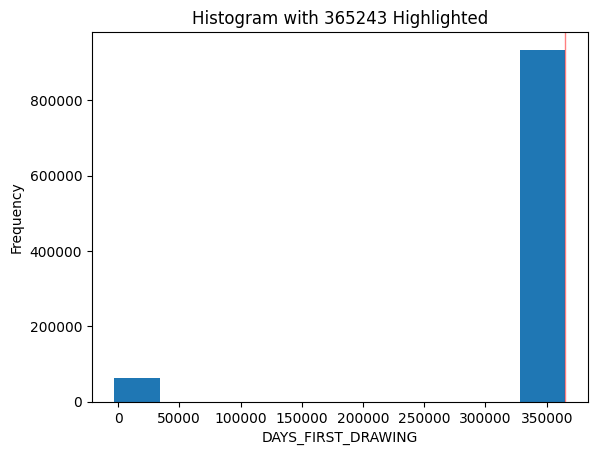

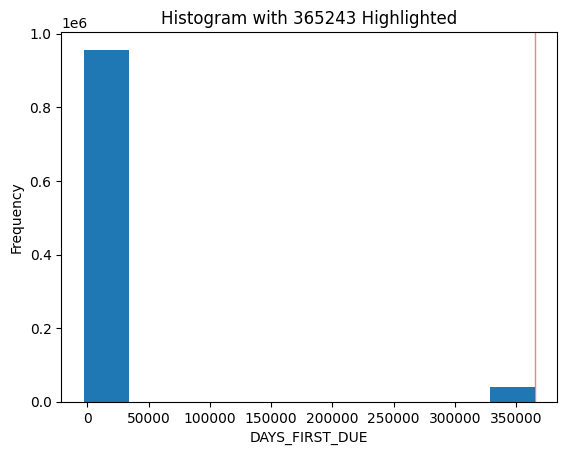

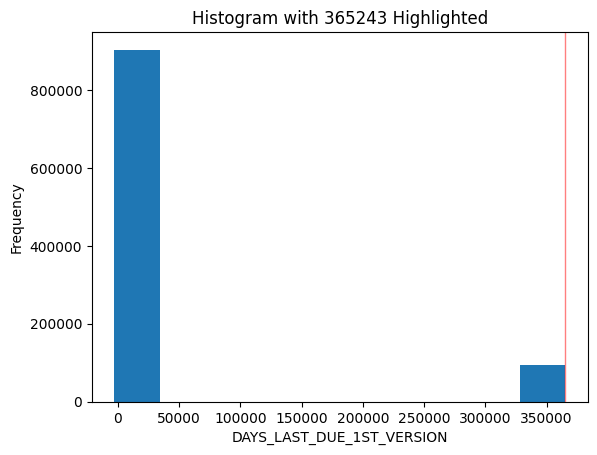

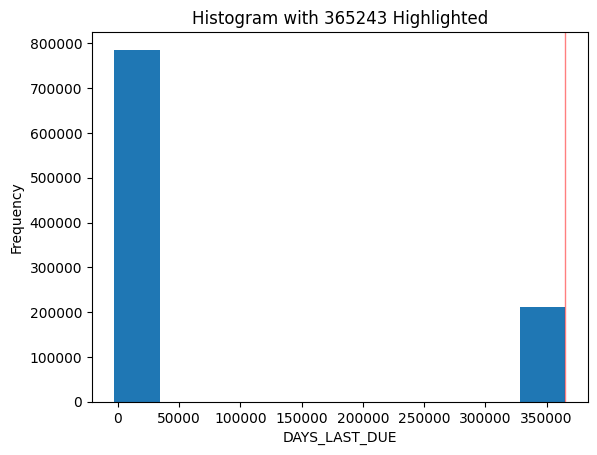

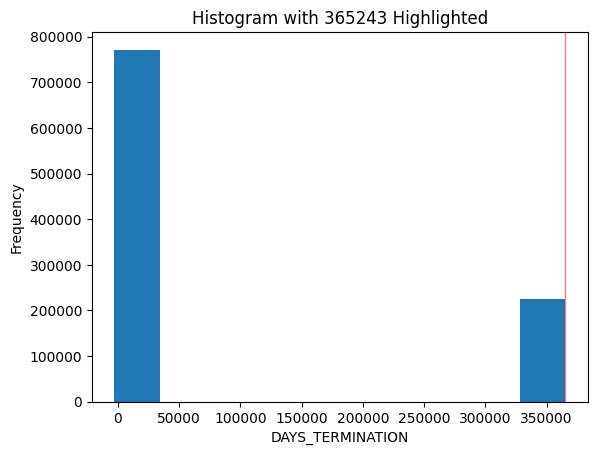

In [107]:
list365243 = abnormal[2:]
highlight_value = 365243  # 要高亮显示的特定值

for col365 in list365243:
    plt.hist(pre_app_encoded[col365])
    plt.axvspan(highlight_value - 0.5, highlight_value + 0.5, color='red', alpha=0.5)     # 高亮显示特定值的区域

    plt.xlabel(col365)
    plt.ylabel('Frequency')
    plt.title('Histogram with 365243 Highlighted')

    plt.show()

In [108]:
for col365 in list365243:
    pre_app_encoded.loc[pre_app_encoded[col365] == 365243, col365] = np.nan

In [109]:
for col365 in list365243:
    print('-------------------')
    print(col365)
    print(pre_app_encoded[col365].describe())

-------------------
DAYS_FIRST_DRAWING
count    62705.000000
mean     -1035.246791
std        922.710316
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64
-------------------
DAYS_FIRST_DUE
count    956504.000000
mean      -1106.583027
std         790.703113
min       -2892.000000
25%       -1676.000000
50%        -874.000000
75%        -459.000000
max          -2.000000
Name: DAYS_FIRST_DUE, dtype: float64
-------------------
DAYS_LAST_DUE_1ST_VERSION
count    903285.000000
mean       -677.158175
std         923.601152
min       -2801.000000
25%       -1359.000000
50%        -480.000000
75%          -2.000000
max        2389.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64
-------------------
DAYS_LAST_DUE
count    785928.000000
mean       -996.179128
std         752.703178
min       -2889.000000
25%       -1566.000000
50%        -801.000000
75%        -353.000000
max          -2

In [110]:
len(pre_app_encoded[pre_app_encoded['DAYS_LAST_DUE_1ST_VERSION']>0])

224392

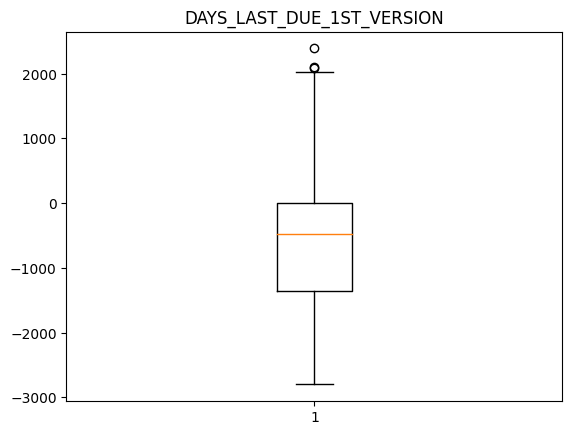

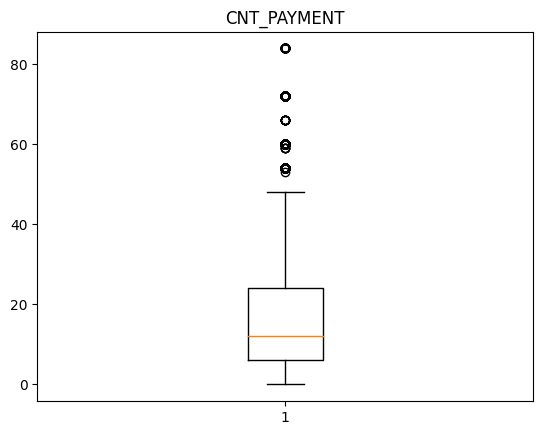

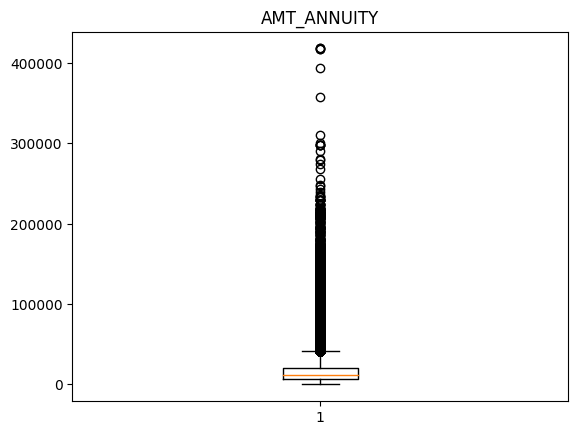

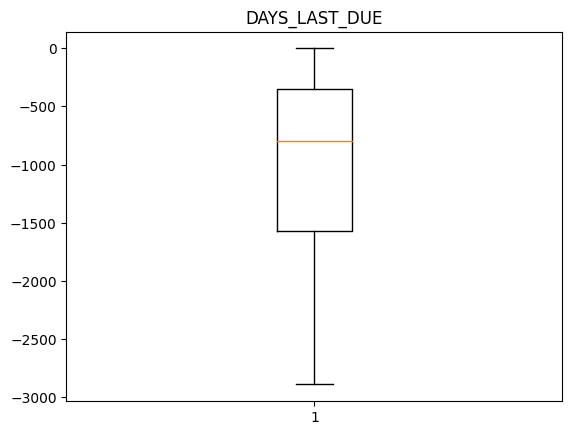

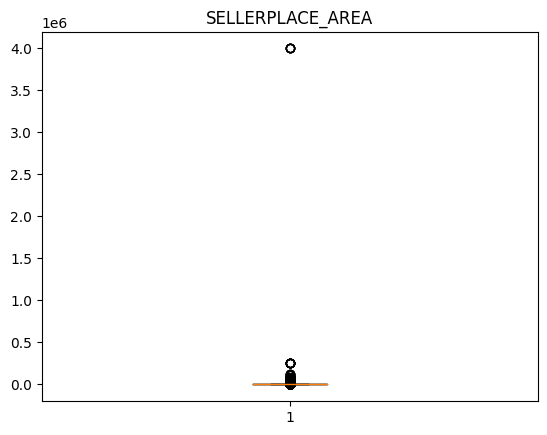

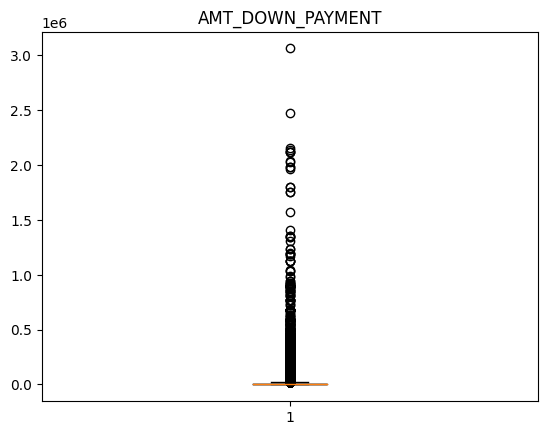

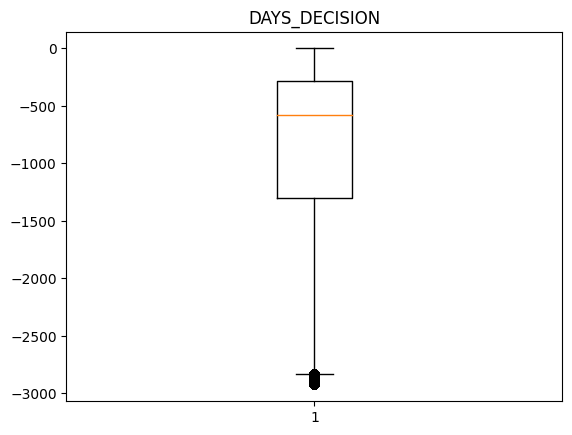

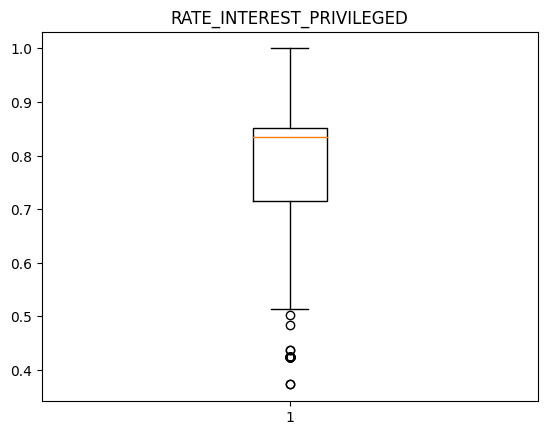

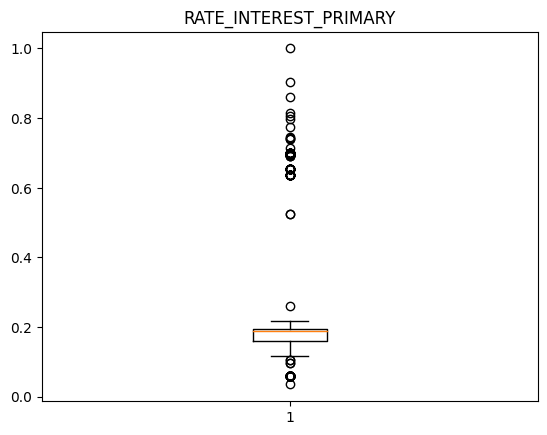

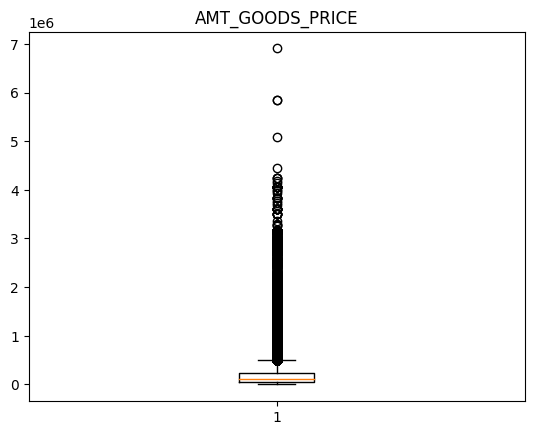

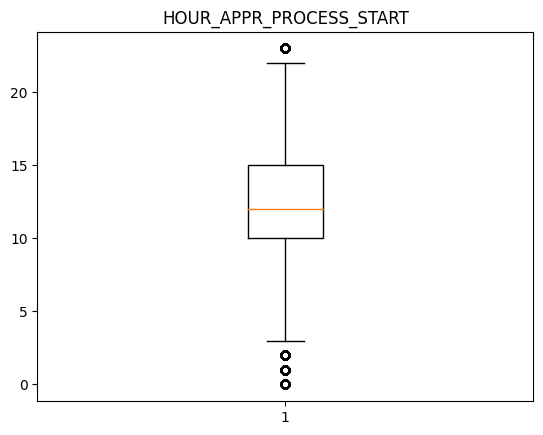

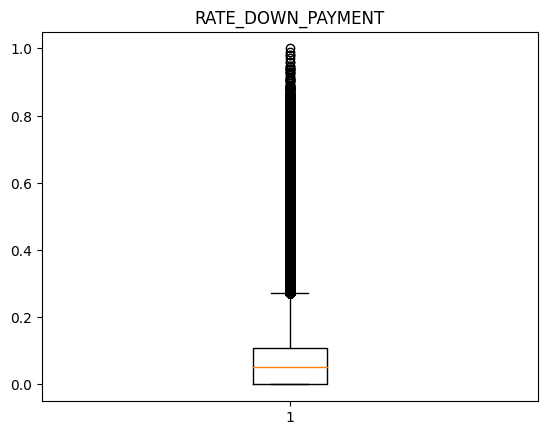

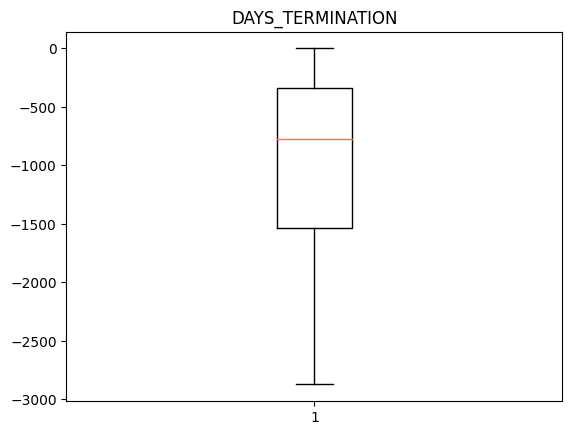

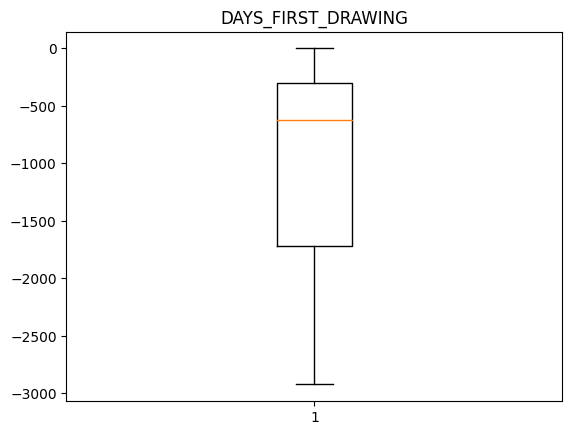

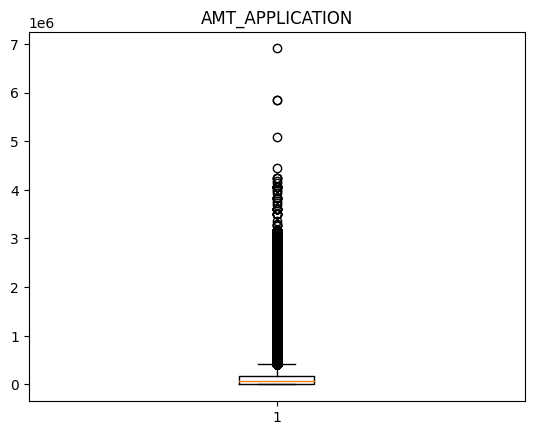

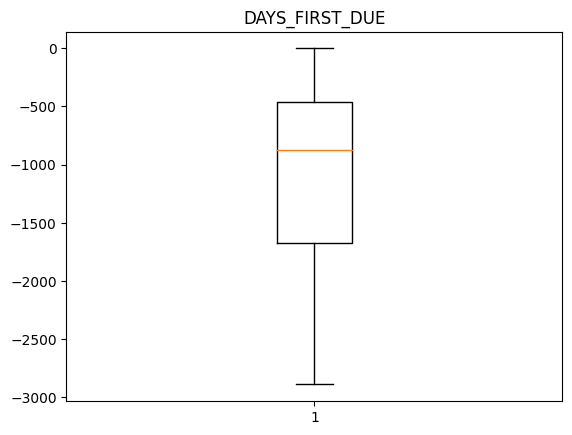

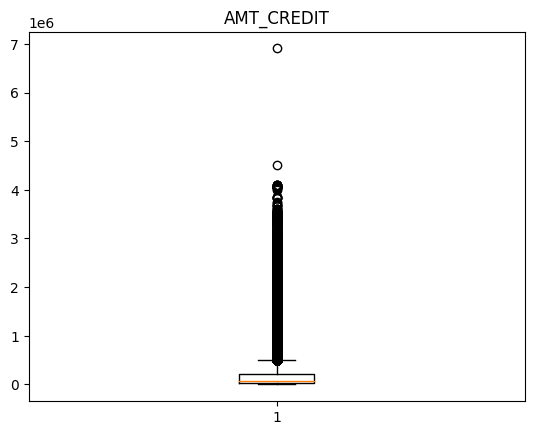

In [111]:
for num_col in pre_num:
    plt.boxplot(pre_app_encoded[num_col].dropna())   
    plt.title(num_col)
    plt.show()

In [112]:
pre_app_encoded[pre_app_encoded['SELLERPLACE_AREA'] == 4000000]

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
151,2783413,269324,5775.615,128205.0,128205.0,0.0,128205.0,20,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
157014,2094519,392616,19317.465,428800.5,428800.5,0.0,428800.5,20,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
310061,2403159,450405,3748.590,83209.5,83209.5,0.0,83209.5,19,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
919667,1125247,228186,2887.830,64102.5,64102.5,0.0,64102.5,18,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
1427909,1993482,390387,14535.180,121450.5,132138.0,0.0,121450.5,13,0.0,NaN,...,True,False,False,False,False,False,False,True,True,False


In [113]:
pre_app_encoded.loc[pre_app_encoded['SELLERPLACE_AREA'] == 4000000, 'SELLERPLACE_AREA'] = np.nan

In [114]:
pre_app_encoded[pre_app_encoded['SELLERPLACE_AREA'] == 4000000]  #检查

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0


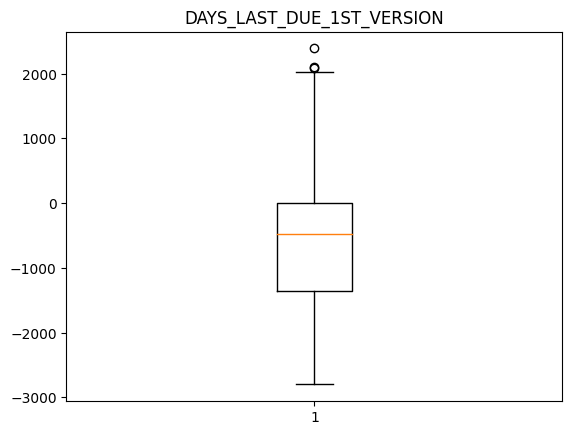

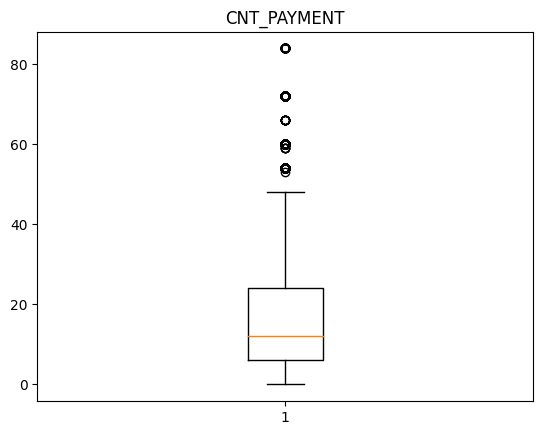

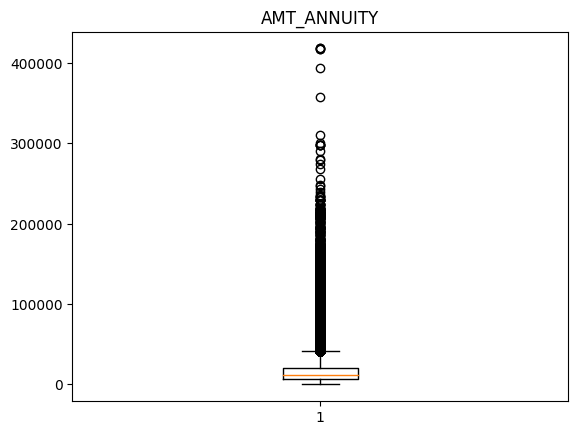

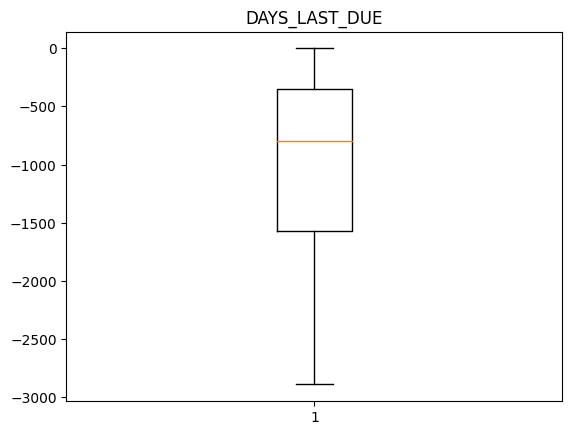

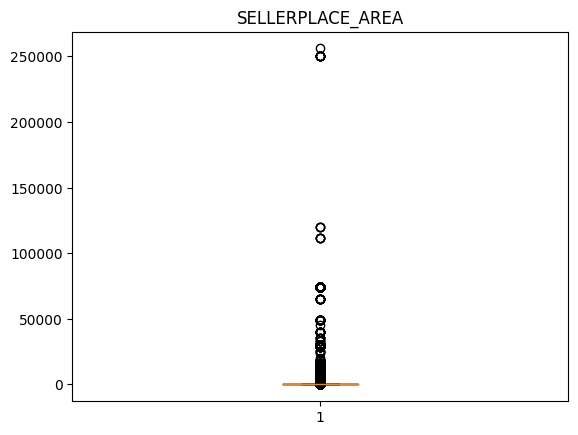

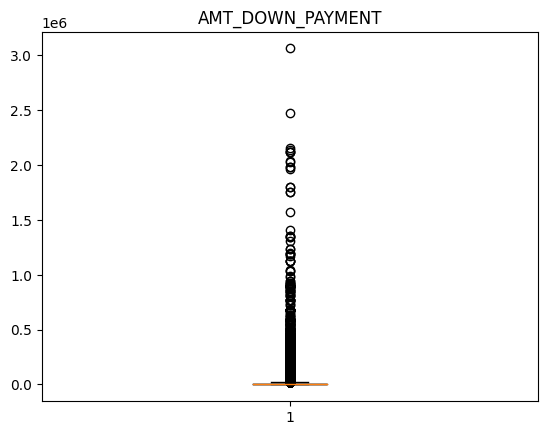

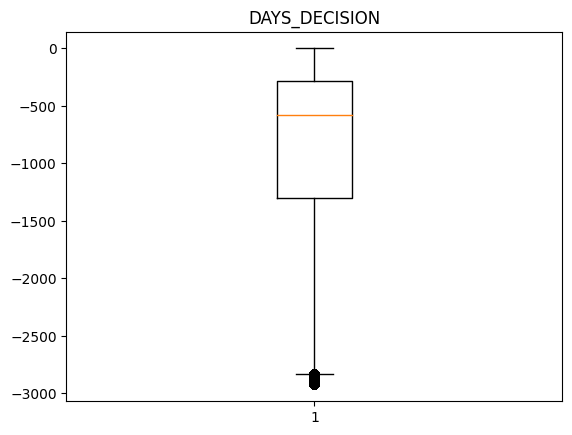

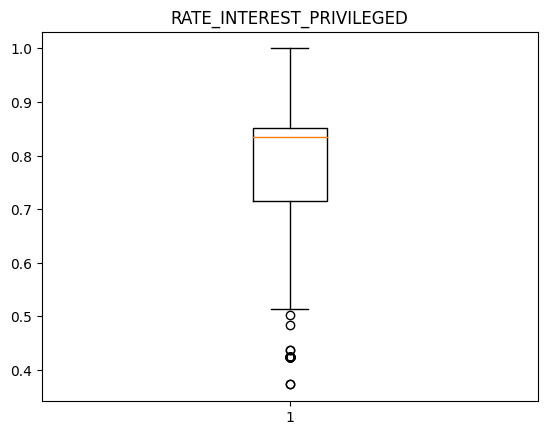

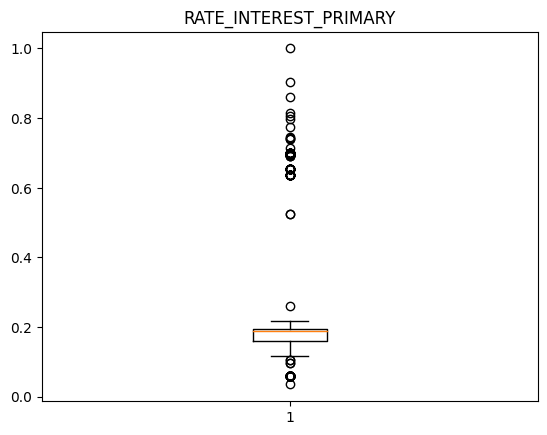

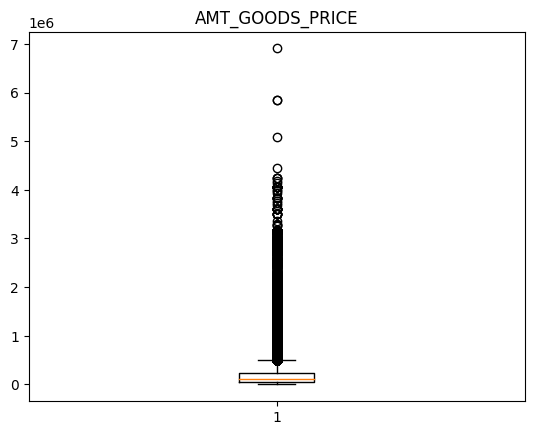

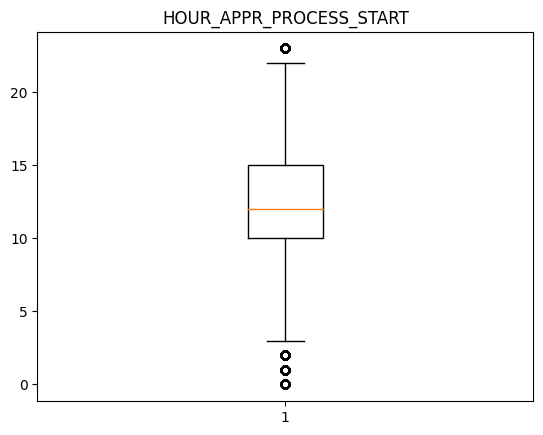

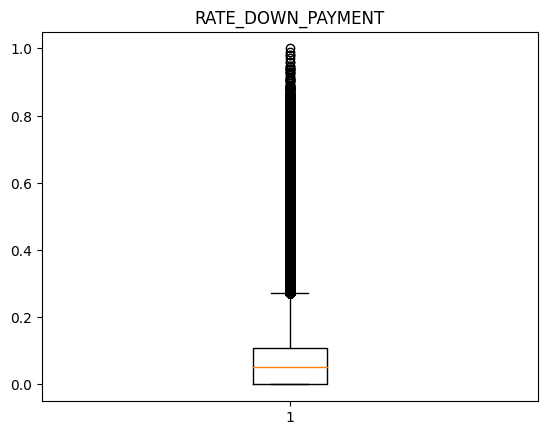

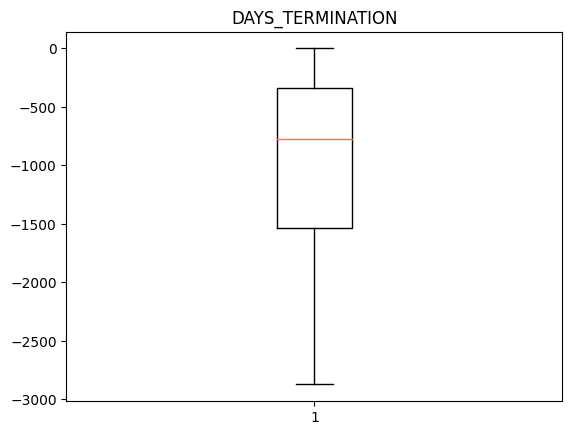

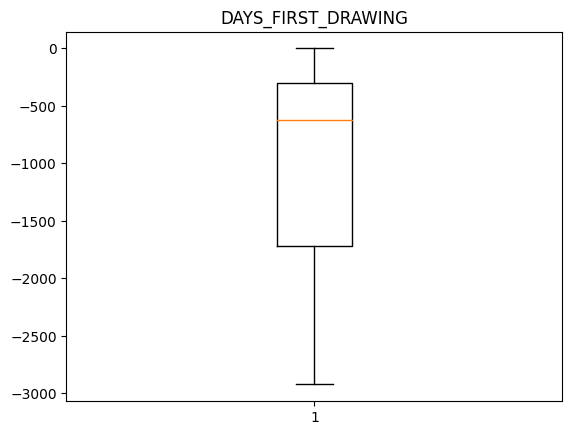

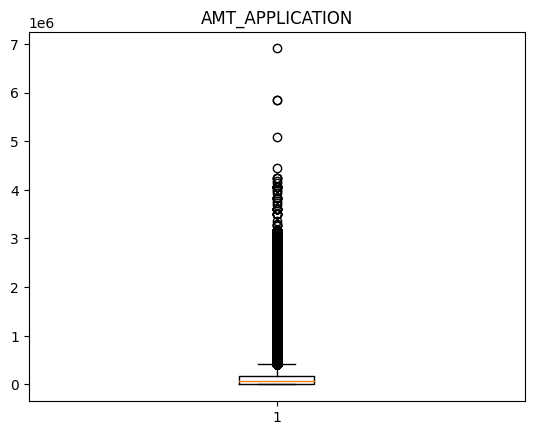

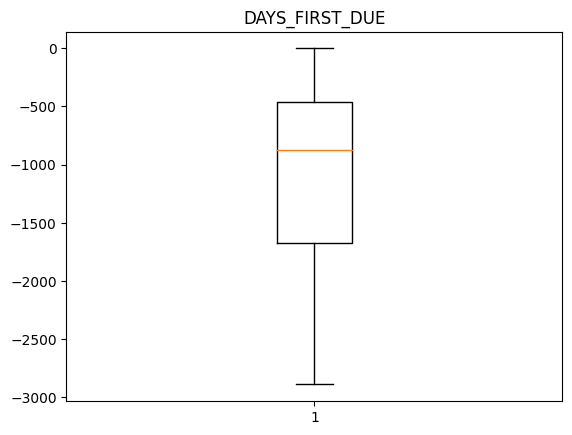

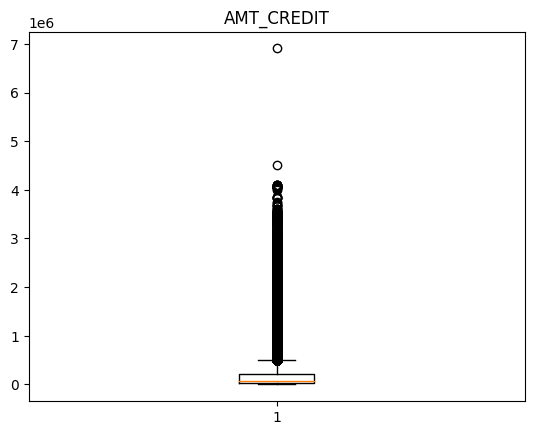

In [115]:
for num_col in pre_num:
    plt.boxplot(pre_app_encoded[num_col].dropna())     #无明显离散表示处理成功
    plt.title(num_col)
    plt.show()

In [116]:
pre_app_encoded['SK_ID_PREV'].value_counts().values.max()

1

In [117]:
pre_app_encoded['SK_ID_CURR'].value_counts().values.max()

77

In [118]:
pre_app_encoded

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,0.000000,0.182832,...,False,False,True,False,False,False,False,True,True,False
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,0.0,267295.5,12,0.000000,NaN,...,True,False,False,False,False,False,False,True,True,False
1670210,2357031,334635,6622.020,87750.0,64291.5,29250.0,87750.0,15,0.340554,NaN,...,True,False,False,False,False,False,False,True,True,False
1670211,2659632,249544,11520.855,105237.0,102523.5,10525.5,105237.0,12,0.101401,NaN,...,False,False,False,False,False,False,False,True,True,False
1670212,2785582,400317,18821.520,180000.0,191880.0,NaN,180000.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True


In [119]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [120]:
type_aggre(pre_app_encoded)

{'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', 'sum', 'var'],
 'CNT_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_ANNUITY': ['min', 'max', 'mean', 'sum', 'var'],
 'SELLERPLACE_AREA': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_LAST_DUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_DECISION': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum', 'var'],
 'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_TERMINATION': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_APPLICATION': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_FIRST_DUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT': ['min', 'max', 'mean', 'sum',

In [121]:
aggregations = type_aggre(pre_app_encoded)

pre_app_encoded_agg = pre_app_encoded.drop(['SK_ID_PREV'], axis=1).groupby('SK_ID_CURR').agg(aggregations)
pre_app_encoded_agg

DAYS_LAST_DUE_1ST_VERSION                                
                                 min     max         mean     sum   
SK_ID_CURR                                                          
100001                       -1499.0 -1499.0 -1499.000000 -1499.0  \
100002                         125.0   125.0   125.000000   125.0   
100003                       -1980.0  -386.0 -1004.333333 -3013.0   
100004                        -694.0  -694.0  -694.000000  -694.0   
100005                        -376.0  -376.0  -376.000000  -376.0   
...                              ...     ...          ...     ...   
456251                           0.0     0.0     0.000000     0.0   
456252                       -2316.0 -2316.0 -2316.000000 -2316.0   
456253                       -2722.0 -1716.0 -2219.000000 -4438.0   
456254                          99.0   203.0   151.000000   302.0   
456255                        -630.0   294.0  -108.333333  -650.0   

                          CNT_PAYMENT                                  ...   
                      var         min   max   mean    sum         var  ...   
SK_ID_CURR                                                             ...   
100001                NaN         8.0   8.0   8.00    8.0         NaN  ...  \
100002                NaN        24.0  24.0  24.00   24.0         NaN  ...   
100003      730974.333333         6.0  12.0  10.00   30.0   12.000000  ...   
100004                NaN         4.0   4.0   4.00    4.0         NaN  ...   
100005                NaN        12.0  12.0  12.00   12.0         NaN  ...   
...                   ...         ...   ...    ...    ...         ...  ...   
456251                NaN         8.0   8.0   8.00    8.0         NaN  ...   
456252                NaN         6.0   6.0   6.00    6.0         NaN  ...   
456253      506018.000000         4.0   6.0   5.00   10.0    2.000000  ...   
456254        5408.000000        14.0  16.0  15.00   30.0    2.000000  ...   
456255      105934.666667         0.0  60.0  21.75  174.0  369.642857  ...   

           PRODUCT_COMBINATION_POS industry with interest   
                                                     mean   
SK_ID_CURR                                                  
100001                                           0.000000  \
100002                                           0.000000   
100003                                           0.333333   
100004                                           0.000000   
100005                                           0.000000   
...                                                   ...   
456251                                           0.000000   
456252                                           0.000000   
456253                                           0.000000   
456254                                           0.000000   
456255                                           0.125000   

           PRODUCT_COMBINATION_POS industry without interest   
                                                        mean   
SK_ID_CURR                                                     
100001                                                   0.0  \
100002                                                   0.0   
100003                                                   0.0   
100004                                                   0.0   
100005                                                   0.0   
...                                                      ...   
456251                                                   0.0   
456252                                                   0.0   
456253                                                   0.0   
456254                                                   0.0   
456255                                                   0.0   

           PRODUCT_COMBINATION_POS mobile with interest   
                                                   mean   
SK_ID_CURR                                                
100001                

### dataset2. bureau

In [122]:
bureau = pd.read_csv('bureau.csv')
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [123]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [124]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [125]:
num_cols, cat_cols = get_cols(bureau)
num_cols

['AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM_DEBT',
 'SK_ID_BUREAU',
 'AMT_ANNUITY',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM',
 'DAYS_CREDIT',
 'DAYS_CREDIT_UPDATE',
 'DAYS_CREDIT_ENDDATE',
 'CNT_CREDIT_PROLONG',
 'CREDIT_DAY_OVERDUE',
 'DAYS_ENDDATE_FACT']

In [126]:
cat_cols

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [127]:
bureau_encoded = bureau.copy()          #创建一个副本以保留原始数据

for col in cat_cols:
    one_hot_encoded = pd.get_dummies(bureau[col], prefix=col)
    bureau_encoded = pd.concat([bureau_encoded, one_hot_encoded], axis=1)
    bureau_encoded.drop(col, axis=1, inplace=True)

bureau_encoded

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,...,False,False,False,False,False,False,False,False,False,False
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,...,False,False,False,False,False,False,False,False,False,False
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,...,False,False,False,False,False,False,False,False,False,False
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,NaN,...,False,False,False,False,False,False,False,False,False,False
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,...,False,False,False,False,False,True,False,False,False,False
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,...,False,False,False,False,False,False,False,False,False,False
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,...,False,False,False,False,False,False,False,False,False,False
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,...,False,False,False,False,False,False,False,False,False,False


In [128]:
for col in num_cols:
    print('-------------------')
    print(col)
    print(bureau_encoded[col].describe())

-------------------
AMT_CREDIT_MAX_OVERDUE
count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64
-------------------
AMT_CREDIT_SUM_DEBT
count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64
-------------------
SK_ID_BUREAU
count    1.716428e+06
mean     5.924434e+06
std      5.322657e+05
min      5.000000e+06
25%      5.463954e+06
50%      5.926304e+06
75%      6.385681e+06
max      6.843457e+06
Name: SK_ID_BUREAU, dtype: float64
-------------------
AMT_ANNUITY
count    4.896370e+05
mean     1.571276e+04
std      3.258269e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.350000e+04
max      1.184534e+08
Name: AMT_ANNUITY, dtype: 

Looking at the statistical values of these different variables, it seems that AMT_CREDIT_SUM_DEBT (complex minimum), AMT_CREDIT_SUM_LIMIT (complex minimum) are more anomalous.

First, deal with the abnormal negative values of AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT (minimum value is negative).

Without doing any processing first, let's see how many such instances there are to decide whether such records are anomalous or not.

In [129]:
abnormal = ['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT']

for potent in abnormal:
    rows = bureau_encoded[bureau_encoded[potent] < 0][potent]
    print('-----------------')
    print(potent)
    print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 8418
-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 351


In [130]:
for col in abnormal:
    print('-------------------')
    print(col)
    print(bureau_encoded[col].describe())

-------------------
AMT_CREDIT_SUM_DEBT
count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64
-------------------
AMT_CREDIT_SUM_LIMIT
count    1.124648e+06
mean     6.229515e+03
std      4.503203e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64


Here, AMT_CREDIT_SUM_DEBT (Current debt on Credit Bureau credit-Current credit limit of credit card reported in the Credit Bureau) and AMT_CREDIT_SUM_LIMIT (Current credit limit of credit card reported in the Credit Bureau-Current credit limit of credit card reported in Credit Bureau) each represent the current debt on Credit Bureau credit and the current credit limit of credit card reported in Credit Bureau, and both variables can be negative, so no exception is recorded here.

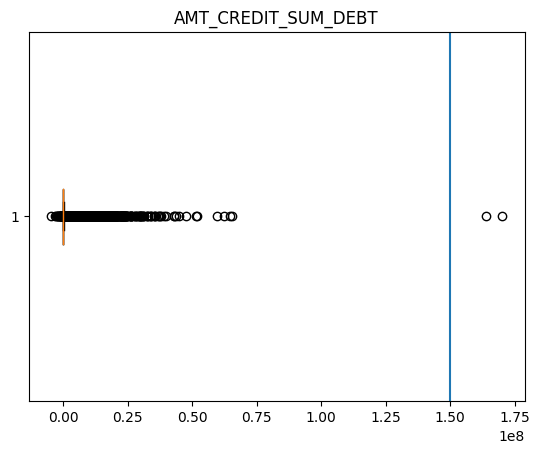

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 2


In [131]:
col = 'AMT_CREDIT_SUM_DEBT'

plt.boxplot(bureau_encoded[col].dropna(), vert=False)   
place = 150000000
plt.axvline(x=place)    # 在箱线图中标出位置

plt.title(col)
plt.show()



potent = 'AMT_CREDIT_SUM_DEBT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

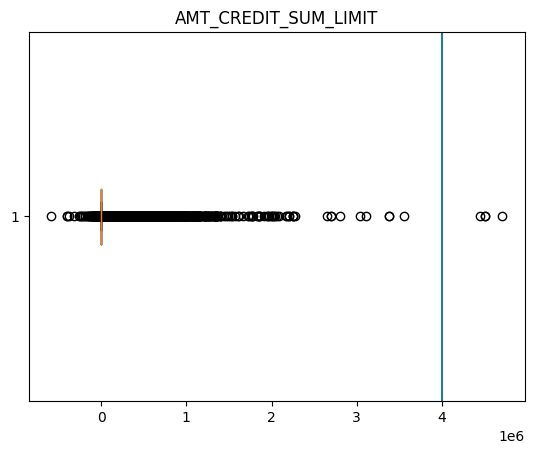

-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 4


In [132]:
col = 'AMT_CREDIT_SUM_LIMIT'

plt.boxplot(bureau_encoded[col].dropna(), vert=False)   
place = 4000000
plt.axvline(x=place)    # 在箱线图中标出位置

plt.title(col)
plt.show()



potent = 'AMT_CREDIT_SUM_LIMIT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

In [133]:
potent = 'AMT_CREDIT_SUM_DEBT'
place = 150000000

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

In [134]:
#检查
potent = 'AMT_CREDIT_SUM_DEBT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 0


In [135]:
potent = 'AMT_CREDIT_SUM_LIMIT'
place = 4000000

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

In [136]:
#检查
potent = 'AMT_CREDIT_SUM_LIMIT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 0


In [137]:
num_cols

['AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM_DEBT',
 'SK_ID_BUREAU',
 'AMT_ANNUITY',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM',
 'DAYS_CREDIT',
 'DAYS_CREDIT_UPDATE',
 'DAYS_CREDIT_ENDDATE',
 'CNT_CREDIT_PROLONG',
 'CREDIT_DAY_OVERDUE',
 'DAYS_ENDDATE_FACT']

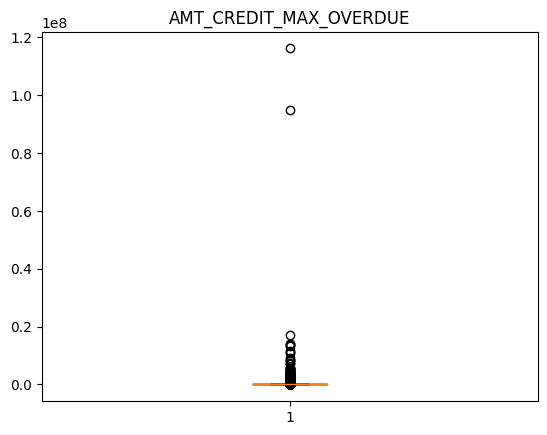

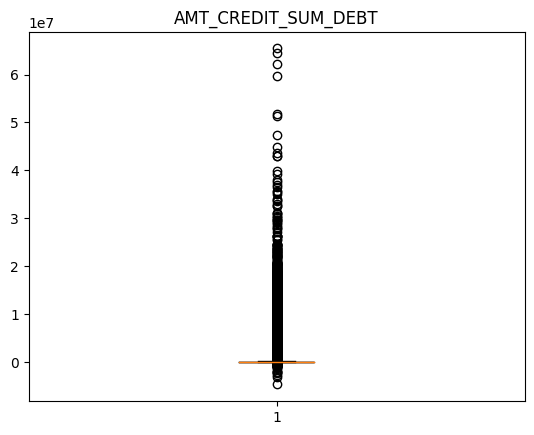

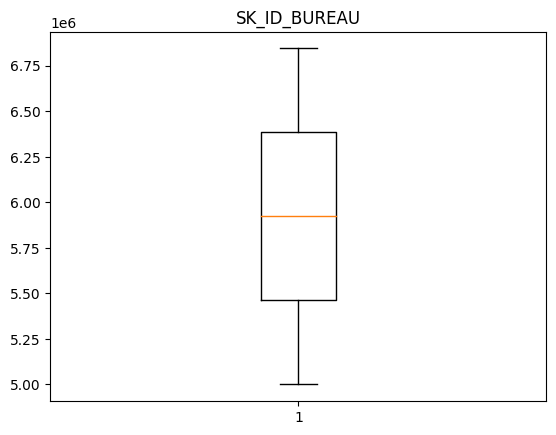

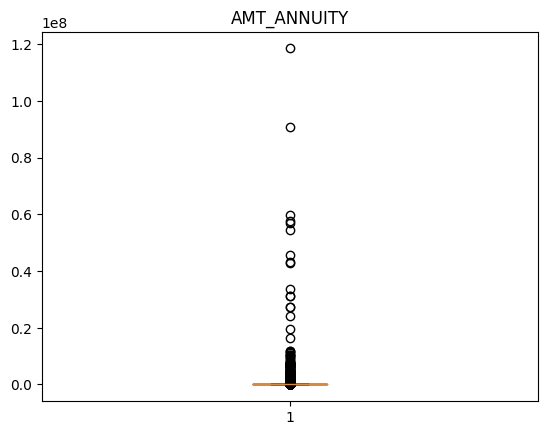

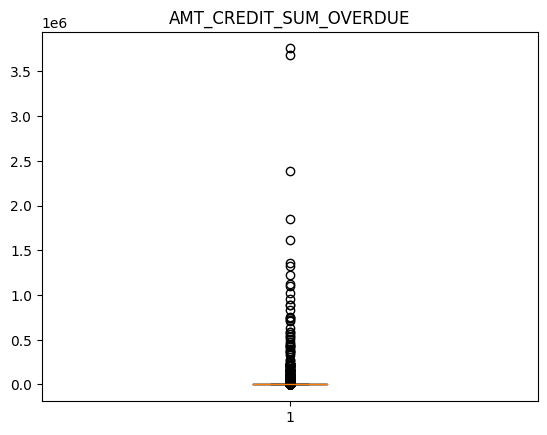

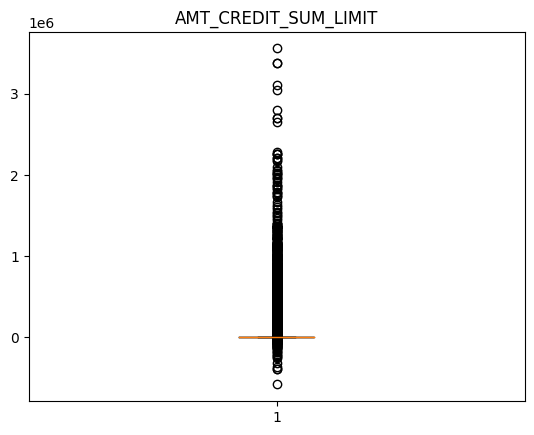

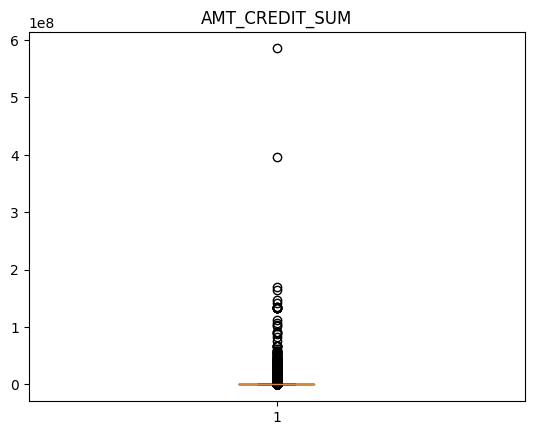

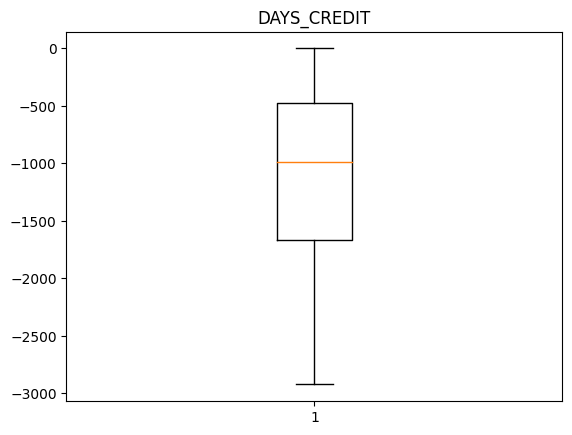

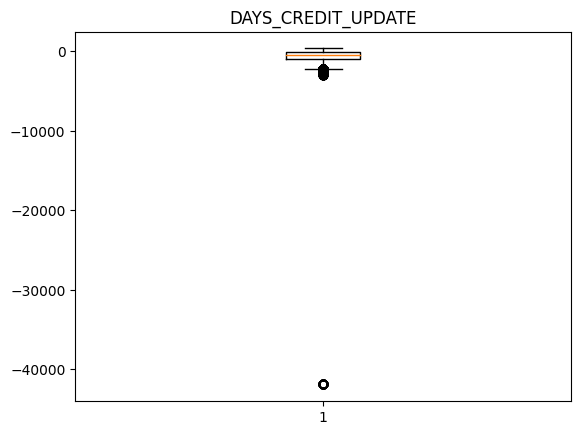

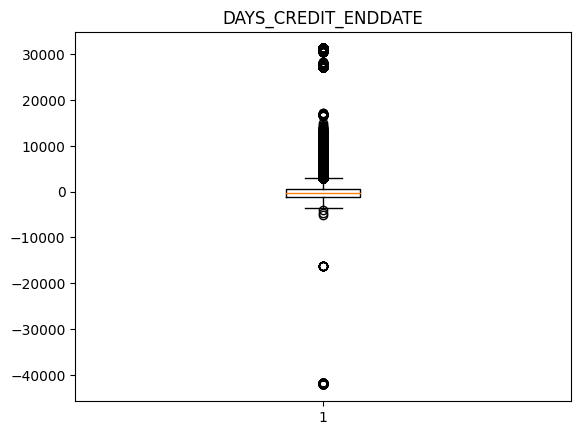

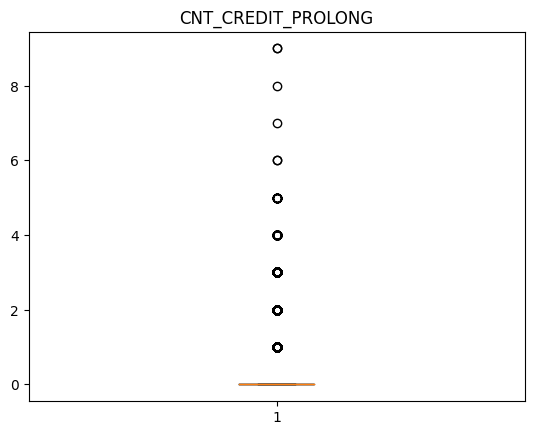

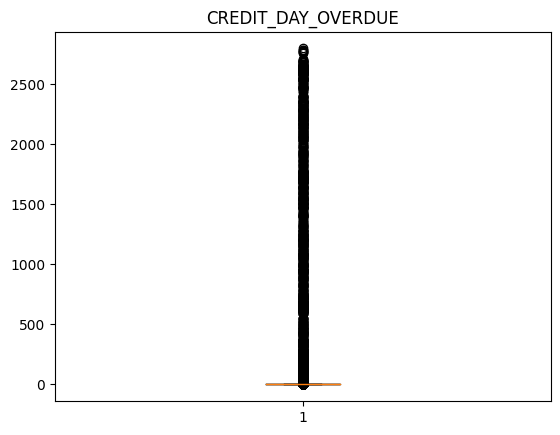

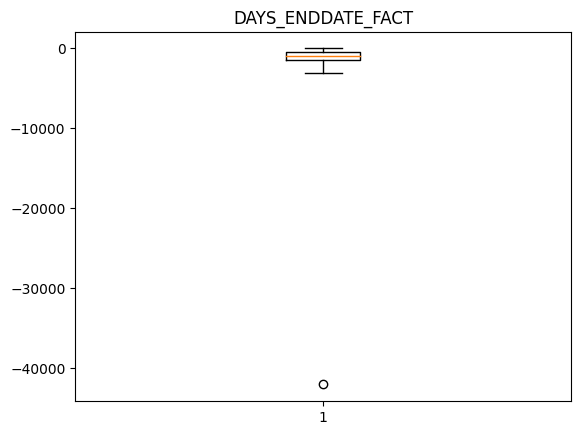

In [138]:
for col in num_cols:
    plt.boxplot(bureau_encoded[col].dropna())     #观察drop后数值是否正常了，无明显离散表示处理成功
    plt.title(col)
    plt.show()

In [139]:
abnormal = ['DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','DAYS_CREDIT_UPDATE']

In [140]:
potent = 'DAYS_CREDIT_ENDDATE'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_CREDIT_ENDDATE
# of cases = 134


In [141]:
potent = 'DAYS_ENDDATE_FACT'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_ENDDATE_FACT
# of cases = 1


In [142]:
potent = 'AMT_CREDIT_MAX_OVERDUE'
place = 0.8*10**8

rows = bureau_encoded[bureau_encoded[potent] > place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_MAX_OVERDUE
# of cases = 2


In [143]:
potent = 'DAYS_CREDIT_UPDATE'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_CREDIT_UPDATE
# of cases = 95


In [144]:
potent = 'DAYS_ENDDATE_FACT'
place = -30000

bureau_encoded.loc[bureau_encoded[potent] < place, potent] = np.nan   #略去异常值的记录

In [145]:
potent = 'AMT_CREDIT_MAX_OVERDUE'
place = 0.8*10**8

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

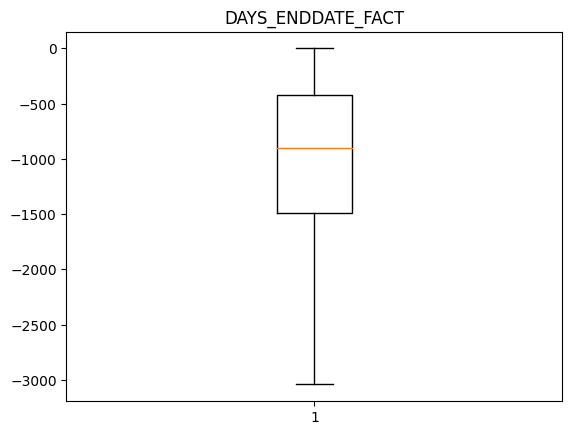

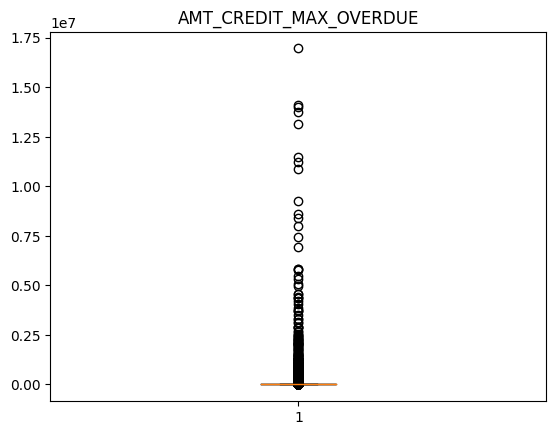

In [146]:
for col in ['DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE']:
    plt.boxplot(bureau_encoded[col].dropna())     #观察drop后数值是否正常了，无明显离散表示处理成功
    plt.title(col)
    plt.show()

In [147]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [148]:
type_aggre(bureau_encoded)

{'AMT_CREDIT_MAX_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean', 'sum', 'var'],
 'SK_ID_BUREAU': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_ANNUITY': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_LIMIT': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'sum', 'var'],
 'CNT_CREDIT_PROLONG': ['min', 'max', 'mean', 'sum', 'var'],
 'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_ENDDATE_FACT': ['min', 'max', 'mean', 'sum', 'var'],
 'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Bad debt': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_CURRENCY_currency 1': ['mean'],
 'CREDIT_CURRENCY_currency 2': ['mean']

In [149]:
aggregations = type_aggre(bureau_encoded)

bureau_encoded_agg = bureau_encoded.groupby('SK_ID_CURR').agg(aggregations)
bureau_encoded_agg

AMT_CREDIT_MAX_OVERDUE                                    
                              min        max       mean        sum   
SK_ID_CURR                                                           
100001                        NaN        NaN        NaN      0.000  \
100002                        0.0   5043.645   1681.029   8405.145   
100003                        0.0      0.000      0.000      0.000   
100004                        0.0      0.000      0.000      0.000   
100005                        0.0      0.000      0.000      0.000   
...                           ...        ...        ...        ...   
456249                        0.0  18945.000   6147.000  30735.000   
456250                        0.0      0.000      0.000      0.000   
456253                        NaN        NaN        NaN      0.000   
456254                        NaN        NaN        NaN      0.000   
456255                        0.0  25578.000  12056.481  60282.405   

                         AMT_CREDIT_SUM_DEBT                              
                     var                 min         max           mean   
SK_ID_CURR                                                                
100001               NaN                 0.0   373239.00   85240.928571  \
100002      5.584936e+06                 0.0   245781.00   49156.200000   
100003      0.000000e+00                 0.0        0.00       0.000000   
100004               NaN                 0.0        0.00       0.000000   
100005               NaN                 0.0   543087.00  189469.500000   
...                  ...                 ...         ...            ...   
456249      7.724727e+07                 0.0   163071.00   16307.100000   
456250      0.000000e+00                 0.0  1840308.48  744013.365000   
456253               NaN                 0.0  1624797.00  448958.250000   
456254               NaN                 0.0        0.00       0.000000   
456255      1.122517e+08                 0.0   595102.50  191864.126250   

                                       ... CREDIT_TYPE_Interbank credit   
                    sum           var  ...                         mean   
SK_ID_CURR                             ...                                
100001       596686.500  1.890230e+10  ...                          0.0  \
100002       245781.000  1.208166e+10  ...                          0.0   
100003            0.000  0.000000e+00  ...                          0.0   
100004            0.000  0.000000e+00  ...                          0.0   
100005       568408.500  9.394430e+10  ...                          0.0   
...                 ...           ...  ...                          ...   
456249       163071.000  2.659215e+09  ...                          0.0   
456250      2232040.095  9.397606e+11  ...                          0.0   
456253      1795833.000  6.209882e+11  ...                          0.0   
456254            0.000           NaN  ...                          0.0   
456255      1534913.010  4.816232e+10  ...                          0.0   

           CREDIT_TYPE_Loan for business development   
                                                mean   
SK_ID_CURR                                             
100001                                           0.0  \
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   
...                                              ...   
456249                                           0.0   
456250                                           0.0   
456253                                           0.0   
456254                                           0.0   
456255                                           0.0   

           CREDIT_TYPE_Loan for purchase of shares (margin lending)   
                                                               mean   
S

### dataset3. application

In [150]:
app = pd.read_csv('application_train.csv')
app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
app.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [152]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [153]:
num_cols, cat_cols = get_cols(app)
num_cols

['NONLIVINGAPARTMENTS_AVG',
 'BASEMENTAREA_MODE',
 'AMT_ANNUITY',
 'APARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_MODE',
 'DAYS_BIRTH',
 'LIVINGAREA_AVG',
 'LIVINGAPARTMENTS_MODE',
 'ELEVATORS_MEDI',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'FLOORSMAX_AVG',
 'ELEVATORS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_MEDI',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ENTRANCES_AVG',
 'AMT_GOODS_PRICE',
 'ELEVATORS_MODE',
 'HOUR_APPR_PROCESS_START',
 'FLOORSMIN_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'REGION_POPULATION_RELATIVE',
 'LIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'FLOORSMAX_MEDI',
 'EXT_SOURCE_1',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'ENTRANCES_MEDI',
 'AMT_INCOME_TOTAL',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'LANDAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'COMMONAREA_MEDI',
 'YEARS_BUILD_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'CNT_FAM_MEMBERS',
 'BASEMENTAREA_AVG',
 'TOTALAREA_MODE',
 'APARTMENTS_AVG',
 'DAYS_REGISTRATION',
 'APARTMENTS_MODE',
 'COMMONAREA_AVG',
 'EXT_SOURCE_2

In [154]:
cat_cols.remove('TARGET')   #单独拎出被预测值TARGET，不做One-Hot处理
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_

In [155]:
app_encoded = app.copy()  #创建一个副本以保留原始数据

for col in cat_cols:
    one_hot_encoded = pd.get_dummies(app[col], prefix=col)
    app_encoded = pd.concat([app_encoded, one_hot_encoded], axis=1)
    app_encoded.drop(col, axis=1, inplace=True)

app_encoded

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,False,True,False,True,False,True,False,False,False,False


In [156]:
for num_col in num_cols:
    print('-------------------')
    print(num_col)
    print(app_encoded[num_col].describe())

-------------------
NONLIVINGAPARTMENTS_AVG
count    93997.000000
mean         0.008809
std          0.047732
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003900
max          1.000000
Name: NONLIVINGAPARTMENTS_AVG, dtype: float64
-------------------
BASEMENTAREA_MODE
count    127568.000000
mean          0.087543
std           0.084307
min           0.000000
25%           0.040700
50%           0.074600
75%           0.112400
max           1.000000
Name: BASEMENTAREA_MODE, dtype: float64
-------------------
AMT_ANNUITY
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
-------------------
APARTMENTS_MEDI
count    151450.000000
mean          0.117850
std           0.109076
min           0.000000
25%           0.058300
50%           0.086400
75%           0.148900
max           1.000000
Na

In [157]:
app_encoded_dropped = app_encoded.copy()
num_col_dropped = num_cols.copy()
count = 0

for num_col in num_cols:
    if sum(app_encoded_dropped[num_col] == 0):
        print('-------------------')
        app_encoded_dropped = app_encoded_dropped.drop([num_col], axis=1)
        num_col_dropped.remove(num_col)
        print(num_col, 'dropped')
        count +=1 

count

-------------------
NONLIVINGAPARTMENTS_AVG dropped
-------------------
BASEMENTAREA_MODE dropped
-------------------
APARTMENTS_MEDI dropped
-------------------
LIVINGAPARTMENTS_AVG dropped
-------------------
NONLIVINGAREA_MODE dropped
-------------------
LIVINGAREA_AVG dropped
-------------------
LIVINGAPARTMENTS_MODE dropped
-------------------
ELEVATORS_MEDI dropped
-------------------
AMT_REQ_CREDIT_BUREAU_WEEK dropped
-------------------
FLOORSMAX_AVG dropped
-------------------
ELEVATORS_AVG dropped
-------------------
LIVINGAPARTMENTS_MEDI dropped
-------------------
FLOORSMIN_MODE dropped
-------------------
YEARS_BUILD_MEDI dropped
-------------------
AMT_REQ_CREDIT_BUREAU_YEAR dropped
-------------------
ENTRANCES_AVG dropped
-------------------
ELEVATORS_MODE dropped
-------------------
HOUR_APPR_PROCESS_START dropped
-------------------
FLOORSMIN_AVG dropped
-------------------
NONLIVINGAPARTMENTS_MODE dropped
-------------------
LIVINGAREA_MEDI dropped
------------------

59

In [158]:
app_encoded_dropped

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,1.0,0.083037,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,2.0,0.311267,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,2.0,NaN,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,1.0,0.145570,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,1.0,NaN,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,1.0,0.744026,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,2.0,NaN,...,False,True,False,True,False,True,False,False,False,False


In [159]:
len(list(set(num_cols) - set(num_col_dropped)))     #去掉了的列的总数

59

In [160]:
for num_col in num_col_dropped:
    print('-------------------')
    print(num_col)
    print(app_encoded_dropped[num_col].describe())

-------------------
AMT_ANNUITY
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
-------------------
DAYS_BIRTH
count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64
-------------------
AMT_GOODS_PRICE
count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64
-------------------
REGION_POPULATION_RELATIVE
count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATI

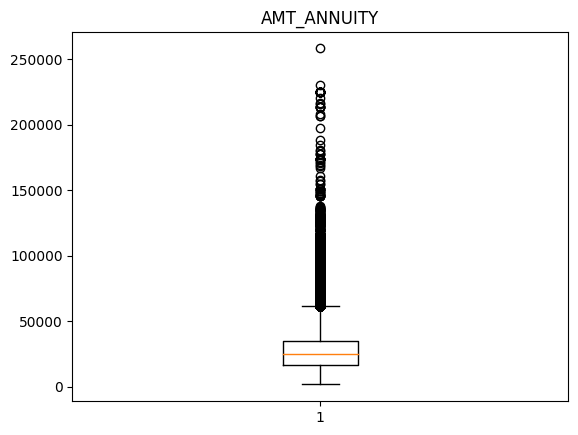

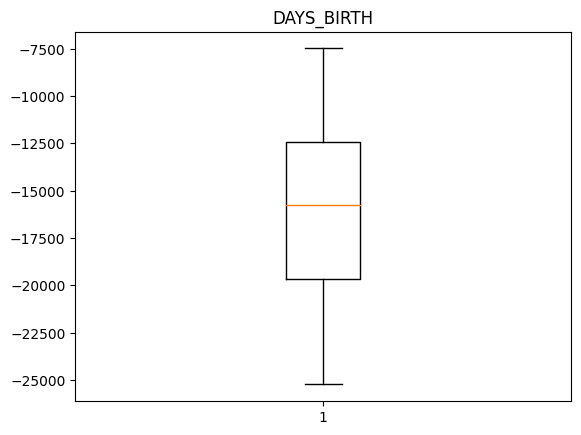

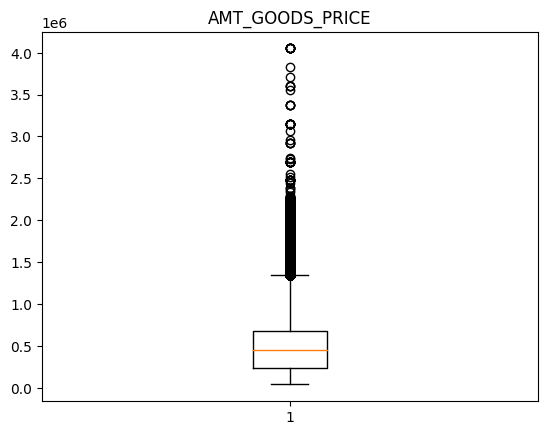

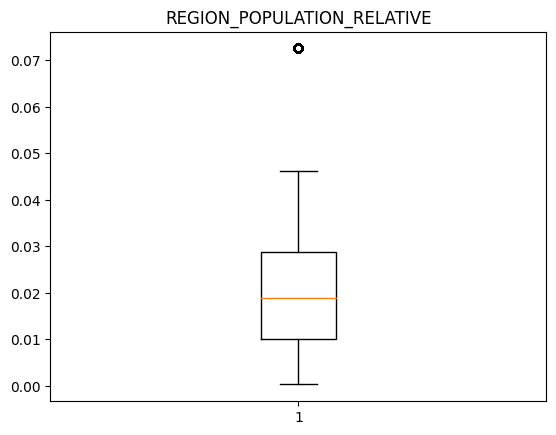

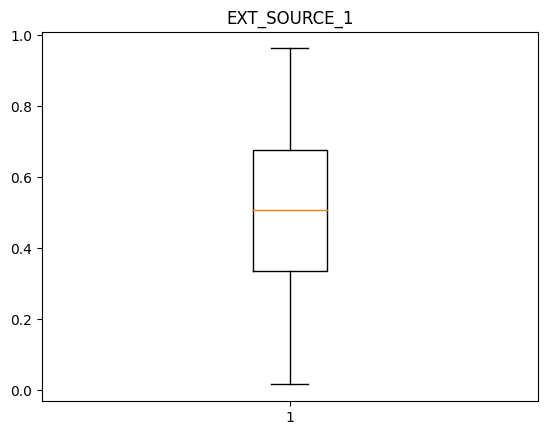

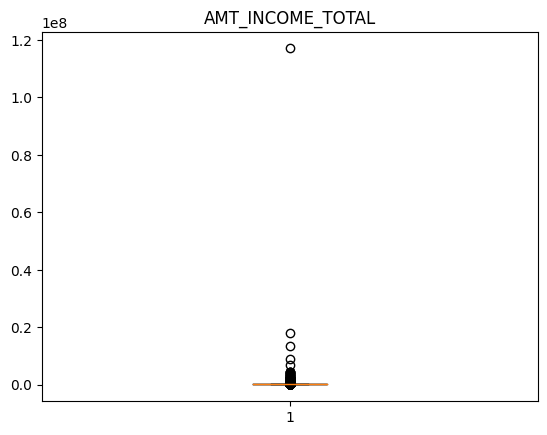

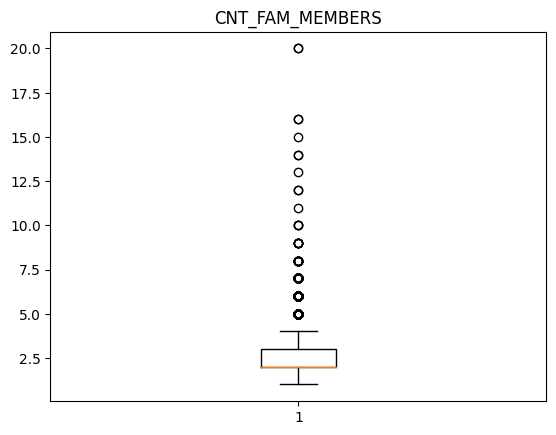

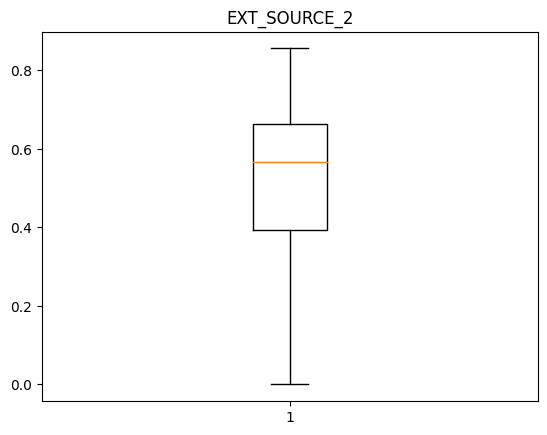

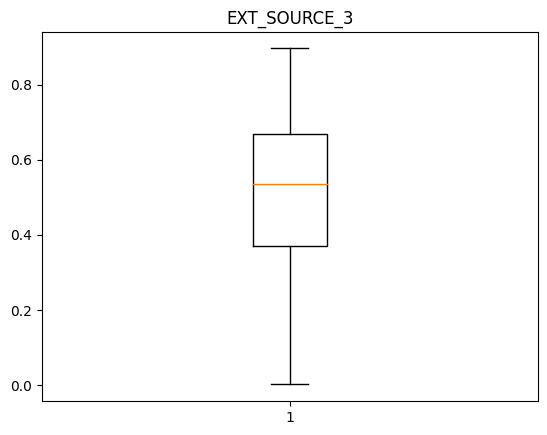

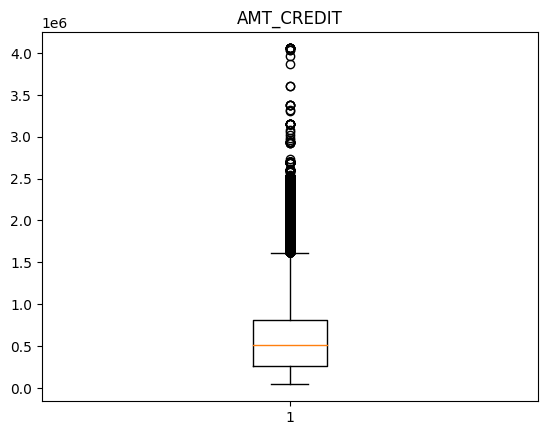

In [161]:
for num_col in num_col_dropped:
    plt.boxplot(app_encoded_dropped[num_col].dropna())
    plt.title(num_col)
    plt.show()

In [162]:
app_encoded_dropped['REGION_POPULATION_RELATIVE'].sort_values(ascending=False)

223701    0.072508
294650    0.072508
10496     0.072508
294671    0.072508
10500     0.072508
            ...   
78542     0.000533
195339    0.000533
257223    0.000533
280258    0.000290
248609    0.000290
Name: REGION_POPULATION_RELATIVE, Length: 307511, dtype: float64

In [163]:
app_encoded_dropped['AMT_INCOME_TOTAL'].sort_values(ascending=False)

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
             ...     
240137        26100.0
186643        26100.0
246104        26100.0
20727         25650.0
1678          25650.0
Name: AMT_INCOME_TOTAL, Length: 307511, dtype: float64

-------------

### merge them

In [164]:
pre_app_encoded_agg

DAYS_LAST_DUE_1ST_VERSION                                
                                 min     max         mean     sum   
SK_ID_CURR                                                          
100001                       -1499.0 -1499.0 -1499.000000 -1499.0  \
100002                         125.0   125.0   125.000000   125.0   
100003                       -1980.0  -386.0 -1004.333333 -3013.0   
100004                        -694.0  -694.0  -694.000000  -694.0   
100005                        -376.0  -376.0  -376.000000  -376.0   
...                              ...     ...          ...     ...   
456251                           0.0     0.0     0.000000     0.0   
456252                       -2316.0 -2316.0 -2316.000000 -2316.0   
456253                       -2722.0 -1716.0 -2219.000000 -4438.0   
456254                          99.0   203.0   151.000000   302.0   
456255                        -630.0   294.0  -108.333333  -650.0   

                          CNT_PAYMENT                                  ...   
                      var         min   max   mean    sum         var  ...   
SK_ID_CURR                                                             ...   
100001                NaN         8.0   8.0   8.00    8.0         NaN  ...  \
100002                NaN        24.0  24.0  24.00   24.0         NaN  ...   
100003      730974.333333         6.0  12.0  10.00   30.0   12.000000  ...   
100004                NaN         4.0   4.0   4.00    4.0         NaN  ...   
100005                NaN        12.0  12.0  12.00   12.0         NaN  ...   
...                   ...         ...   ...    ...    ...         ...  ...   
456251                NaN         8.0   8.0   8.00    8.0         NaN  ...   
456252                NaN         6.0   6.0   6.00    6.0         NaN  ...   
456253      506018.000000         4.0   6.0   5.00   10.0    2.000000  ...   
456254        5408.000000        14.0  16.0  15.00   30.0    2.000000  ...   
456255      105934.666667         0.0  60.0  21.75  174.0  369.642857  ...   

           PRODUCT_COMBINATION_POS industry with interest   
                                                     mean   
SK_ID_CURR                                                  
100001                                           0.000000  \
100002                                           0.000000   
100003                                           0.333333   
100004                                           0.000000   
100005                                           0.000000   
...                                                   ...   
456251                                           0.000000   
456252                                           0.000000   
456253                                           0.000000   
456254                                           0.000000   
456255                                           0.125000   

           PRODUCT_COMBINATION_POS industry without interest   
                                                        mean   
SK_ID_CURR                                                     
100001                                                   0.0  \
100002                                                   0.0   
100003                                                   0.0   
100004                                                   0.0   
100005                                                   0.0   
...                                                      ...   
456251                                                   0.0   
456252                                                   0.0   
456253                                                   0.0   
456254                                                   0.0   
456255                                                   0.0   

           PRODUCT_COMBINATION_POS mobile with interest   
                                                   mean   
SK_ID_CURR                                                
100001                

In [165]:
pre_app_encoded_agg.columns = pre_app_encoded_agg.columns.to_flat_index()
pre_app_encoded_agg

,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(CNT_PAYMENT, min)","(CNT_PAYMENT, max)","(CNT_PAYMENT, mean)","(CNT_PAYMENT, sum)","(CNT_PAYMENT, var)",...,"(PRODUCT_COMBINATION_POS industry with interest, mean)","(PRODUCT_COMBINATION_POS industry without interest, mean)","(PRODUCT_COMBINATION_POS mobile with interest, mean)","(PRODUCT_COMBINATION_POS mobile without interest, mean)","(PRODUCT_COMBINATION_POS other with interest, mean)","(PRODUCT_COMBINATION_POS others without interest, mean)","(NFLAG_LAST_APPL_IN_DAY_0, mean)","(NFLAG_LAST_APPL_IN_DAY_1, mean)","(NFLAG_INSURED_ON_APPROVAL_0.0, mean)","(NFLAG_INSURED_ON_APPROVAL_1.0, mean)"
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1499.0,-1499.0,-1499.000000,-1499.0,NaN,8.0,8.0,8.00,8.0,NaN,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
100002,125.0,125.0,125.000000,125.0,NaN,24.0,24.0,24.00,24.0,NaN,...,0.000000,0.0,0.00,0.0,1.0,0.0,0.0,1.0,1.000000,0.000000
100003,-1980.0,-386.0,-1004.333333,-3013.0,730974.333333,6.0,12.0,10.00,30.0,12.000000,...,0.333333,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
100004,-694.0,-694.0,-694.000000,-694.0,NaN,4.0,4.0,4.00,4.0,NaN,...,0.000000,0.0,0.00,1.0,0.0,0.0,0.0,1.0,1.000000,0.000000
100005,-376.0,-376.0,-376.000000,-376.0,NaN,12.0,12.0,12.00,12.0,NaN,...,0.000000,0.0,0.50,0.0,0.0,0.0,0.0,1.0,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.000000,0.0,NaN,8.0,8.0,8.00,8.0,NaN,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
456252,-2316.0,-2316.0,-2316.000000,-2316.0,NaN,6.0,6.0,6.00,6.0,NaN,...,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000
456253,-2722.0,-1716.0,-2219.000000,-4438.0,506018.000000,4.0,6.0,5.00,10.0,2.000000,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000


In [166]:
bureau_encoded_agg

AMT_CREDIT_MAX_OVERDUE                                    
                              min        max       mean        sum   
SK_ID_CURR                                                           
100001                        NaN        NaN        NaN      0.000  \
100002                        0.0   5043.645   1681.029   8405.145   
100003                        0.0      0.000      0.000      0.000   
100004                        0.0      0.000      0.000      0.000   
100005                        0.0      0.000      0.000      0.000   
...                           ...        ...        ...        ...   
456249                        0.0  18945.000   6147.000  30735.000   
456250                        0.0      0.000      0.000      0.000   
456253                        NaN        NaN        NaN      0.000   
456254                        NaN        NaN        NaN      0.000   
456255                        0.0  25578.000  12056.481  60282.405   

                         AMT_CREDIT_SUM_DEBT                              
                     var                 min         max           mean   
SK_ID_CURR                                                                
100001               NaN                 0.0   373239.00   85240.928571  \
100002      5.584936e+06                 0.0   245781.00   49156.200000   
100003      0.000000e+00                 0.0        0.00       0.000000   
100004               NaN                 0.0        0.00       0.000000   
100005               NaN                 0.0   543087.00  189469.500000   
...                  ...                 ...         ...            ...   
456249      7.724727e+07                 0.0   163071.00   16307.100000   
456250      0.000000e+00                 0.0  1840308.48  744013.365000   
456253               NaN                 0.0  1624797.00  448958.250000   
456254               NaN                 0.0        0.00       0.000000   
456255      1.122517e+08                 0.0   595102.50  191864.126250   

                                       ... CREDIT_TYPE_Interbank credit   
                    sum           var  ...                         mean   
SK_ID_CURR                             ...                                
100001       596686.500  1.890230e+10  ...                          0.0  \
100002       245781.000  1.208166e+10  ...                          0.0   
100003            0.000  0.000000e+00  ...                          0.0   
100004            0.000  0.000000e+00  ...                          0.0   
100005       568408.500  9.394430e+10  ...                          0.0   
...                 ...           ...  ...                          ...   
456249       163071.000  2.659215e+09  ...                          0.0   
456250      2232040.095  9.397606e+11  ...                          0.0   
456253      1795833.000  6.209882e+11  ...                          0.0   
456254            0.000           NaN  ...                          0.0   
456255      1534913.010  4.816232e+10  ...                          0.0   

           CREDIT_TYPE_Loan for business development   
                                                mean   
SK_ID_CURR                                             
100001                                           0.0  \
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   
...                                              ...   
456249                                           0.0   
456250                                           0.0   
456253                                           0.0   
456254                                           0.0   
456255                                           0.0   

           CREDIT_TYPE_Loan for purchase of shares (margin lending)   
                                                               mean   
S

In [167]:
bureau_encoded_agg.columns = bureau_encoded_agg.columns.to_flat_index()
bureau_encoded_agg

,"(AMT_CREDIT_MAX_OVERDUE, min)","(AMT_CREDIT_MAX_OVERDUE, max)","(AMT_CREDIT_MAX_OVERDUE, mean)","(AMT_CREDIT_MAX_OVERDUE, sum)","(AMT_CREDIT_MAX_OVERDUE, var)","(AMT_CREDIT_SUM_DEBT, min)","(AMT_CREDIT_SUM_DEBT, max)","(AMT_CREDIT_SUM_DEBT, mean)","(AMT_CREDIT_SUM_DEBT, sum)","(AMT_CREDIT_SUM_DEBT, var)",...,"(CREDIT_TYPE_Interbank credit, mean)","(CREDIT_TYPE_Loan for business development, mean)","(CREDIT_TYPE_Loan for purchase of shares (margin lending), mean)","(CREDIT_TYPE_Loan for the purchase of equipment, mean)","(CREDIT_TYPE_Loan for working capital replenishment, mean)","(CREDIT_TYPE_Microloan, mean)","(CREDIT_TYPE_Mobile operator loan, mean)","(CREDIT_TYPE_Mortgage, mean)","(CREDIT_TYPE_Real estate loan, mean)","(CREDIT_TYPE_Unknown type of loan, mean)"
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,NaN,NaN,NaN,0.000,NaN,0.0,373239.00,85240.928571,596686.500,1.890230e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,0.0,5043.645,1681.029,8405.145,5.584936e+06,0.0,245781.00,49156.200000,245781.000,1.208166e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,0.0,0.000,0.000,0.000,0.000000e+00,0.0,0.00,0.000000,0.000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0.0,0.000,0.000,0.000,NaN,0.0,0.00,0.000000,0.000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,0.0,0.000,0.000,0.000,NaN,0.0,543087.00,189469.500000,568408.500,9.394430e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,0.0,18945.000,6147.000,30735.000,7.724727e+07,0.0,163071.00,16307.100000,163071.000,2.659215e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456250,0.0,0.000,0.000,0.000,0.000000e+00,0.0,1840308.48,744013.365000,2232040.095,9.397606e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456253,NaN,NaN,NaN,0.000,NaN,0.0,1624797.00,448958.250000,1795833.000,6.209882e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
app_encoded_dropped

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,1.0,0.083037,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,2.0,0.311267,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,2.0,NaN,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,1.0,0.145570,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,1.0,NaN,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,1.0,0.744026,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,2.0,NaN,...,False,True,False,True,False,True,False,False,False,False


In [169]:
merged1 = pd.merge(pre_app_encoded_agg, bureau_encoded_agg, on='SK_ID_CURR')
merged_final = pd.merge(merged1, app_encoded_dropped, on='SK_ID_CURR')
merged_final

C:\Users\98768\AppData\Local\Temp\ipykernel_30560\3158792317.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged1 = pd.merge(pre_app_encoded_agg, bureau_encoded_agg, on='SK_ID_CURR')
C:\Users\98768\AppData\Local\Temp\ipykernel_30560\3158792317.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_final = pd.merge(merged1, app_encoded_dropped, on='SK_ID_CURR')


,SK_ID_CURR,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(CNT_PAYMENT, min)","(CNT_PAYMENT, max)","(CNT_PAYMENT, mean)","(CNT_PAYMENT, sum)",...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,125.0,125.0,125.000000,125.0,NaN,24.0,24.0,24.000000,24.0,...,False,True,False,True,False,True,False,False,False,False
1,100003,-1980.0,-386.0,-1004.333333,-3013.0,7.309743e+05,6.0,12.0,10.000000,30.0,...,False,True,False,True,False,True,False,False,False,False
2,100004,-694.0,-694.0,-694.000000,-694.0,NaN,4.0,4.0,4.000000,4.0,...,False,True,False,True,False,True,False,False,False,False
3,100007,-2056.0,346.0,-837.200000,-4186.0,8.701652e+05,10.0,48.0,20.666667,124.0,...,False,True,False,True,False,True,False,False,False,False
4,100008,-2341.0,261.0,-1044.500000,-4178.0,1.768694e+06,6.0,30.0,14.000000,56.0,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249502,456247,-2722.0,-329.0,-1336.750000,-5347.0,1.430713e+06,4.0,12.0,7.750000,31.0,...,False,True,False,True,False,True,False,False,False,False
249503,456249,-1165.0,-1165.0,-1165.000000,-1165.0,NaN,12.0,12.0,12.000000,24.0,...,False,True,False,True,False,True,False,False,False,False
249504,456253,-2722.0,-1716.0,-2219.000000,-4438.0,5.060180e+05,4.0,6.0,5.000000,10.0,...,False,True,False,True,False,False,True,False,False,False
249505,456254,99.0,203.0,151.000000,302.0,5.408000e+03,14.0,16.0,15.000000,30.0,...,False,True,False,True,False,True,False,False,False,False


In [197]:
merged_final['TARGET'].value_counts()

TARGET
0    229939
1     19568
Name: count, dtype: int64

In [200]:
merged_final['TARGET'].value_counts()[0]/merged_final['TARGET'].value_counts()[1]

11.750766557645134

### Step 2. modeling, feeding dataset (XGBoost, LightGBM)

In [170]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

from xgboost import XGBClassifier
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

from tqdm import tqdm

import matplotlib.pyplot as plt

In [171]:
list(merged_final.columns).remove('TARGET')

In [172]:
features = list(merged_final.columns)
features.remove('TARGET')
features

['SK_ID_CURR',
 ('DAYS_LAST_DUE_1ST_VERSION', 'min'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'max'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'mean'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'sum'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'var'),
 ('CNT_PAYMENT', 'min'),
 ('CNT_PAYMENT', 'max'),
 ('CNT_PAYMENT', 'mean'),
 ('CNT_PAYMENT', 'sum'),
 ('CNT_PAYMENT', 'var'),
 "('AMT_ANNUITY', 'min')_x",
 "('AMT_ANNUITY', 'max')_x",
 "('AMT_ANNUITY', 'mean')_x",
 "('AMT_ANNUITY', 'sum')_x",
 "('AMT_ANNUITY', 'var')_x",
 ('SELLERPLACE_AREA', 'min'),
 ('SELLERPLACE_AREA', 'max'),
 ('SELLERPLACE_AREA', 'mean'),
 ('SELLERPLACE_AREA', 'sum'),
 ('SELLERPLACE_AREA', 'var'),
 ('DAYS_LAST_DUE', 'min'),
 ('DAYS_LAST_DUE', 'max'),
 ('DAYS_LAST_DUE', 'mean'),
 ('DAYS_LAST_DUE', 'sum'),
 ('DAYS_LAST_DUE', 'var'),
 ('AMT_DOWN_PAYMENT', 'min'),
 ('AMT_DOWN_PAYMENT', 'max'),
 ('AMT_DOWN_PAYMENT', 'mean'),
 ('AMT_DOWN_PAYMENT', 'sum'),
 ('AMT_DOWN_PAYMENT', 'var'),
 ('DAYS_DECISION', 'min'),
 ('DAYS_DECISION', 'max'),
 ('DAYS_DECISION', 'mean'

In [173]:
X = merged_final[features]
X

,SK_ID_CURR,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(CNT_PAYMENT, min)","(CNT_PAYMENT, max)","(CNT_PAYMENT, mean)","(CNT_PAYMENT, sum)",...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,125.0,125.0,125.000000,125.0,NaN,24.0,24.0,24.000000,24.0,...,False,True,False,True,False,True,False,False,False,False
1,100003,-1980.0,-386.0,-1004.333333,-3013.0,7.309743e+05,6.0,12.0,10.000000,30.0,...,False,True,False,True,False,True,False,False,False,False
2,100004,-694.0,-694.0,-694.000000,-694.0,NaN,4.0,4.0,4.000000,4.0,...,False,True,False,True,False,True,False,False,False,False
3,100007,-2056.0,346.0,-837.200000,-4186.0,8.701652e+05,10.0,48.0,20.666667,124.0,...,False,True,False,True,False,True,False,False,False,False
4,100008,-2341.0,261.0,-1044.500000,-4178.0,1.768694e+06,6.0,30.0,14.000000,56.0,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249502,456247,-2722.0,-329.0,-1336.750000,-5347.0,1.430713e+06,4.0,12.0,7.750000,31.0,...,False,True,False,True,False,True,False,False,False,False
249503,456249,-1165.0,-1165.0,-1165.000000,-1165.0,NaN,12.0,12.0,12.000000,24.0,...,False,True,False,True,False,True,False,False,False,False
249504,456253,-2722.0,-1716.0,-2219.000000,-4438.0,5.060180e+05,4.0,6.0,5.000000,10.0,...,False,True,False,True,False,False,True,False,False,False
249505,456254,99.0,203.0,151.000000,302.0,5.408000e+03,14.0,16.0,15.000000,30.0,...,False,True,False,True,False,True,False,False,False,False


In [174]:
X.columns.values

array(['SK_ID_CURR', ('DAYS_LAST_DUE_1ST_VERSION', 'min'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'max'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'mean'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'sum'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'var'), ('CNT_PAYMENT', 'min'),
       ('CNT_PAYMENT', 'max'), ('CNT_PAYMENT', 'mean'),
       ('CNT_PAYMENT', 'sum'), ('CNT_PAYMENT', 'var'),
       "('AMT_ANNUITY', 'min')_x", "('AMT_ANNUITY', 'max')_x",
       "('AMT_ANNUITY', 'mean')_x", "('AMT_ANNUITY', 'sum')_x",
       "('AMT_ANNUITY', 'var')_x", ('SELLERPLACE_AREA', 'min'),
       ('SELLERPLACE_AREA', 'max'), ('SELLERPLACE_AREA', 'mean'),
       ('SELLERPLACE_AREA', 'sum'), ('SELLERPLACE_AREA', 'var'),
       ('DAYS_LAST_DUE', 'min'), ('DAYS_LAST_DUE', 'max'),
       ('DAYS_LAST_DUE', 'mean'), ('DAYS_LAST_DUE', 'sum'),
       ('DAYS_LAST_DUE', 'var'), ('AMT_DOWN_PAYMENT', 'min'),
       ('AMT_DOWN_PAYMENT', 'max'), ('AMT_DOWN_PAYMENT', 'mean'),
       ('AMT_DOWN_PAYMENT', 'sum'), ('AMT_DOWN_PAYMENT',

In [175]:
columns = [str(col) for col in X.columns]
X.rename(columns=dict(zip(X.columns, columns)), inplace=True)
X.columns = X.columns.str.replace("_", "/").str.replace('(', '/').str.replace(')', '/').str.replace(':', '/').str.replace(',', '/')

X.columns.values

C:\Users\98768\AppData\Local\Temp\ipykernel_30560\1820746351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=dict(zip(X.columns, columns)), inplace=True)


array(['SK/ID/CURR', "/'DAYS/LAST/DUE/1ST/VERSION'/ 'min'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'max'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'mean'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'sum'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'var'/", "/'CNT/PAYMENT'/ 'min'/",
       "/'CNT/PAYMENT'/ 'max'/", "/'CNT/PAYMENT'/ 'mean'/",
       "/'CNT/PAYMENT'/ 'sum'/", "/'CNT/PAYMENT'/ 'var'/",
       "/'AMT/ANNUITY'/ 'min'//x", "/'AMT/ANNUITY'/ 'max'//x",
       "/'AMT/ANNUITY'/ 'mean'//x", "/'AMT/ANNUITY'/ 'sum'//x",
       "/'AMT/ANNUITY'/ 'var'//x", "/'SELLERPLACE/AREA'/ 'min'/",
       "/'SELLERPLACE/AREA'/ 'max'/", "/'SELLERPLACE/AREA'/ 'mean'/",
       "/'SELLERPLACE/AREA'/ 'sum'/", "/'SELLERPLACE/AREA'/ 'var'/",
       "/'DAYS/LAST/DUE'/ 'min'/", "/'DAYS/LAST/DUE'/ 'max'/",
       "/'DAYS/LAST/DUE'/ 'mean'/", "/'DAYS/LAST/DUE'/ 'sum'/",
       "/'DAYS/LAST/DUE'/ 'var'/", "/'AMT/DOWN/PAYMENT'/ 'min'/",
       "/'AMT/DOWN/PAYMENT'/ 'max'/", "/'AMT/DOWN/PAYMENT'/ 'mean'/",
       "/'

In [176]:
y = merged_final['TARGET']
y

0         1
1         0
2         0
3         0
4         0
         ..
249502    0
249503    0
249504    0
249505    1
249506    0
Name: TARGET, Length: 249507, dtype: int64

In [177]:
merged_final['TARGET'].value_counts().values[0]/merged_final['TARGET'].value_counts().values[1]  #计算scale_pos_weight

11.750766557645134

In [178]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'gamma':0.25560865378490555, 
'learning_rate':0.07461139976709795, 
'max_depth':3, 
'min_child_weight':9, 
'n_estimators':428, 
'reg_alpha':0.0, 
'reg_lambda':0.5304630959073479, 
'subsample':0.7813822517885592,
'scale_pos_weight': 11.750766557645134
}

# 创建 XGBoost 分类器，并使用最佳超参数进行训练
xgbmodel1 = XGBClassifier(**best_params)
xgbmodel1.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgbmodel1.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.7689825647535078


In [179]:
y_pred_proba = xgbmodel1.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.893344,0.106656
1,0.700733,0.299267
2,0.243099,0.756901
3,0.684120,0.315880
4,0.502182,0.497818
...,...,...
49897,0.650093,0.349907
49898,0.656026,0.343974
49899,0.323587,0.676413
49900,0.379013,0.620987


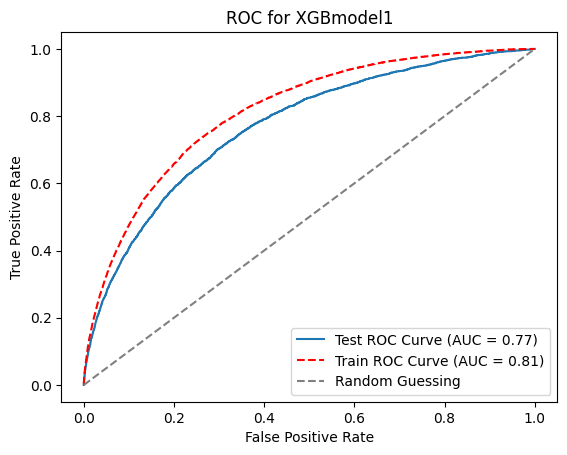

In [202]:
# 在测试集上进行预测
y_pred = xgbmodel1.predict_proba(X_test)[:, 1]
y_train_pred = xgbmodel1.predict_proba(X_train)[:, 1]

y_true = y_test  # 真实标签
y_scores = y_pred  # 测试集预测的为1的概率
y_train_scores = y_train_pred  # 训练集预测的为1的概率

# 计算测试集的 ROC 曲线参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 计算训练集的 ROC 曲线参数
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
auc_train = roc_auc_score(y_train, y_train_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='Test ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train), linestyle='--', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBmodel1')
plt.legend()
plt.show()

In [181]:
y_pred = xgbmodel1.predict(X_test)   #threshold为0.5
cm = confusion_matrix(y_test, y_pred)

true_positive = cm[1, 1]
true_negative = cm[0, 0]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

print('XGBoost:')
print('--------------')
print('True Positive:', true_positive)
print('--------------')
print('True Negative:', true_negative)
print('--------------')
print('False Positive:', false_positive)
print('--------------')
print('False Negative:', false_negative)

XGBoost:
--------------
True Positive: 2594
--------------
True Negative: 33503
--------------
False Positive: 12511
--------------
False Negative: 1294


threshold改为0.3。

In [182]:
y_pred = np.where(xgbmodel1.predict_proba(X_test)[:, 1] >= 0.3, 1, 0)    #threshold为0.3
#y_pred = xgbmodel1.predict(X_test)   #threshold为0.3
cm = confusion_matrix(y_test, y_pred)

true_positive = cm[1, 1]
true_negative = cm[0, 0]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

print('XGBoost:')
print('--------------')
print('True Positive:', true_positive)
print('--------------')
print('True Negative:', true_negative)
print('--------------')
print('False Positive:', false_positive)
print('--------------')
print('False Negative:', false_negative)

XGBoost:
--------------
True Positive: 3446
--------------
True Negative: 19640
--------------
False Positive: 26374
--------------
False Negative: 442


Precision = TP / (TP + FP)

How many of all the individuals with a positive prediction were right


Recall = TP / (TP + FN)     

How many of all individuals with positive true values are right

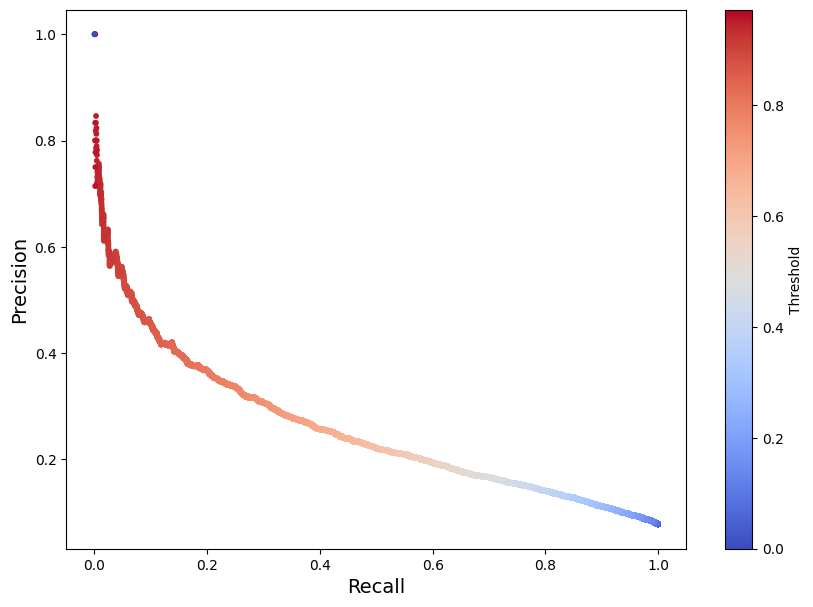

In [183]:
y_scores = xgbmodel1.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [184]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'gamma': 0.19949772291032702,
'learning_rate': 0.06366804652592485,
'max_depth': 5,
'n_estimators': 300,
'subsample': 0.8798331303185938,
'scale_pos_weight': 11.750766557645134
}

# 创建 XGBoost 分类器，并使用最佳超参数进行训练
xgbmodel2 = XGBClassifier(**best_params)
xgbmodel2.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgbmodel2.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.766884759286


In [185]:
y_pred_proba = xgbmodel2.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.923618,0.076382
1,0.746723,0.253277
2,0.256044,0.743956
3,0.704649,0.295351
4,0.399758,0.600242
...,...,...
49897,0.737494,0.262506
49898,0.734226,0.265774
49899,0.300434,0.699566
49900,0.381967,0.618033


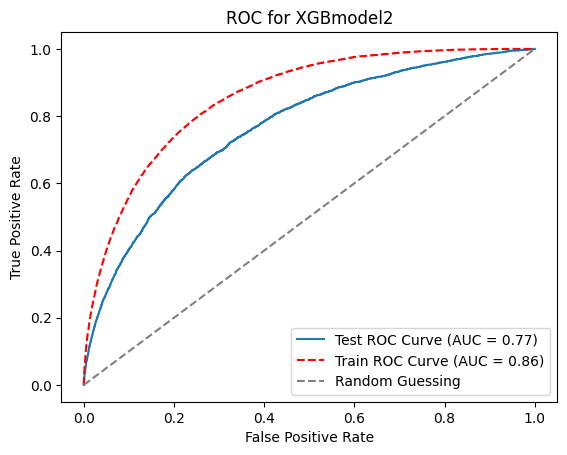

In [186]:
# 在测试集上进行预测
y_pred = xgbmodel2.predict_proba(X_test)[:, 1]
y_train_pred = xgbmodel2.predict_proba(X_train)[:, 1]

y_true = y_test  # 真实标签
y_scores = y_pred  # 测试集预测的为1的概率
y_train_scores = y_train_pred  # 训练集预测的为1的概率

# 计算测试集的 ROC 曲线参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 计算训练集的 ROC 曲线参数
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
auc_train = roc_auc_score(y_train, y_train_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='Test ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train), linestyle='--', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBmodel2')
plt.legend()
plt.show()

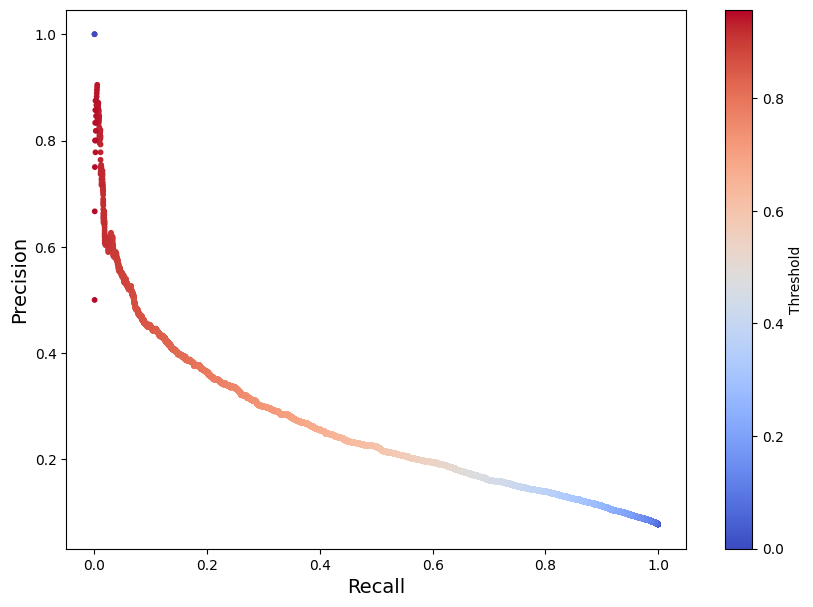

In [187]:
y_scores = xgbmodel2.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [188]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'learning_rate':0.07461139976709795, 
'max_depth':3, 
'min_child_weight':9, 
'min_split_gain':0.25560865378490555, 
'n_estimators':428, 
'reg_alpha':0.0, 
'reg_lambda':0.5304630959073479, 
'subsample':0.7813822517885592,
'scale_pos_weight': 11.750766557645134
}

lgbmmodel1 = lgb.LGBMClassifier(**best_params)
lgbmmodel1.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lgbmmodel1.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.768801739933865


In [189]:
y_pred_proba = lgbmmodel1.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.885385,0.114615
1,0.722624,0.277376
2,0.265053,0.734947
3,0.660184,0.339816
4,0.471557,0.528443
...,...,...
49897,0.723433,0.276567
49898,0.591562,0.408438
49899,0.341038,0.658962
49900,0.309804,0.690196


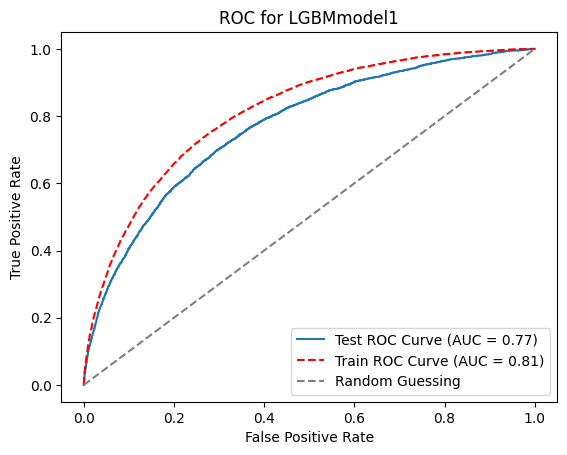

In [203]:
# 在测试集上进行预测
y_pred = lgbmmodel1.predict_proba(X_test)[:, 1]
y_train_pred = lgbmmodel1.predict_proba(X_train)[:, 1]

y_true = y_test  # 真实标签
y_scores = y_pred  # 测试集预测的为1的概率
y_train_scores = y_train_pred  # 训练集预测的为1的概率

# 计算测试集的 ROC 曲线参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 计算训练集的 ROC 曲线参数
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
auc_train = roc_auc_score(y_train, y_train_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='Test ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train), linestyle='--', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LGBMmodel1')
plt.legend()
plt.show()

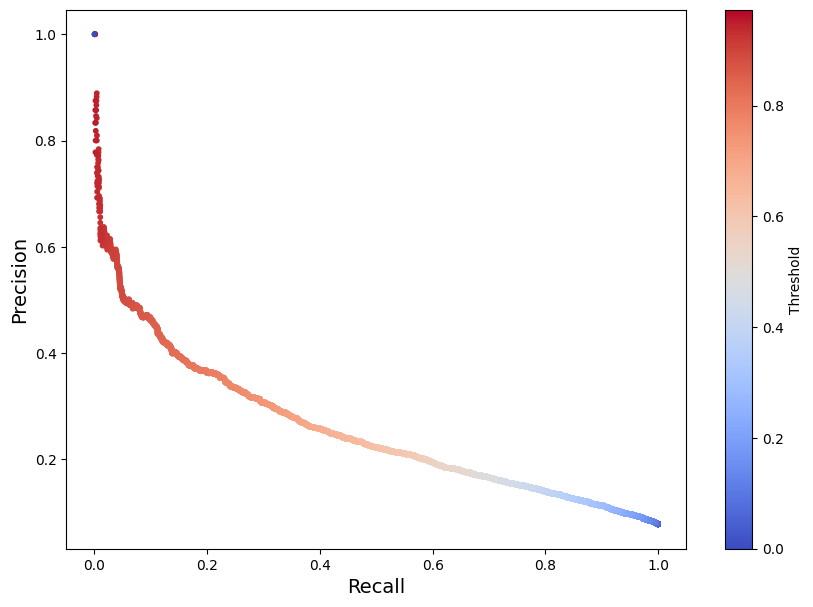

In [191]:
y_scores = lgbmmodel1.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [192]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'learning_rate': 0.05104629857953324, 
'max_depth': int(8.066583652537123), 
'min_child_weight': int(2.7970640394252375), 
'min_split_gain': 0.5142344384136116, 
'n_estimators': int(336.965827544817), 
'reg_alpha': 0.046450412719997725, 
'reg_lambda': 0.6075448519014384, 
'subsample': 0.5852620618436457,
'scale_pos_weight': 11.750766557645134
}

lgbmmodel2 = lgb.LGBMClassifier(**best_params)
lgbmmodel2.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lgbmmodel2.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.7684778259470504


In [193]:
y_pred_proba = lgbmmodel2.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.884927,0.115073
1,0.723969,0.276031
2,0.296335,0.703665
3,0.712033,0.287967
4,0.556955,0.443045
...,...,...
49897,0.608678,0.391322
49898,0.673287,0.326713
49899,0.298025,0.701975
49900,0.446108,0.553892


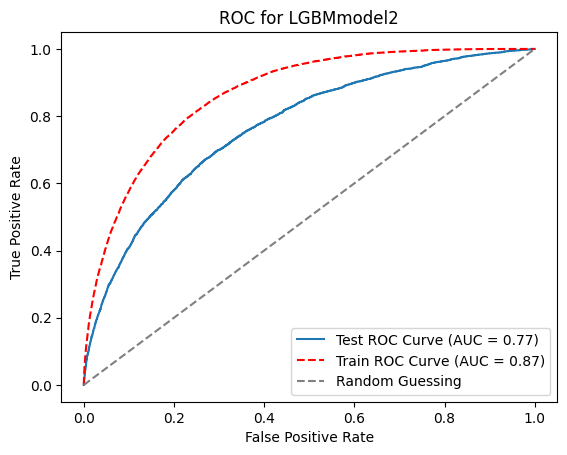

In [204]:
# 在测试集上进行预测
y_pred = lgbmmodel2.predict_proba(X_test)[:, 1]
y_train_pred = lgbmmodel2.predict_proba(X_train)[:, 1]

y_true = y_test  # 真实标签
y_scores = y_pred  # 测试集预测的为1的概率
y_train_scores = y_train_pred  # 训练集预测的为1的概率

# 计算测试集的 ROC 曲线参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 计算训练集的 ROC 曲线参数
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
auc_train = roc_auc_score(y_train, y_train_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='Test ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train), linestyle='--', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LGBMmodel2')
plt.legend()
plt.show()

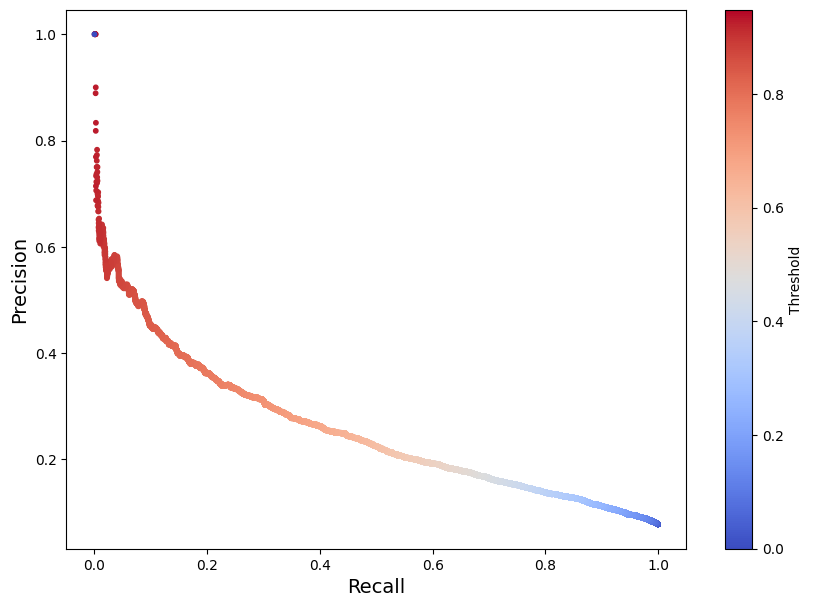

In [195]:
y_scores = lgbmmodel2.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

### Step 3. Bayes Optimization

Skopt (XGB)

In [ ]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 XGBoost 分类器
model = XGBClassifier()

# 定义超参数的搜索范围
param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'gamma': (0.0, 0.5),
    'min_child_weight': (1, 10),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

# 使用贝叶斯优化进行超参数优化
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, scoring='roc_auc', cv=10, n_iter=50)

# 添加进度条显示
with tqdm(total=50) as pbar:  # 设置进度条总长度为 50
    def on_step(optim_result):
        pbar.update(1)  # 每完成一次优化步骤，更新进度条进度

    bayes_search.fit(X_train, y_train, callback=on_step)

# 输出贝叶斯优化的结果
print("Bayesian Optimization - Best Parameters: ", bayes_search.best_params_)
print("Bayesian Optimization - Best Score: ", bayes_search.best_score_)

100%|██████████| 50/50 [28:34:53<00:00, 2057.88s/it]   

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.25560865378490555), ('learning_rate', 0.07461139976709795), ('max_depth', 3), ('min_child_weight', 9), ('n_estimators', 428), ('reg_alpha', 0.0), ('reg_lambda', 0.5304630959073479), ('subsample', 0.7813822517885592)])
Bayesian Optimization - Best Score:  0.779785101630243


### Skopt Output（XGB）。

#### Output1:

100%|██████████| 50/50 [13:36:18<00:00, 979.57s/it]   

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.19949772291032702), 
                                                       ('learning_rate', 0.06366804652592485), 
                                                       ('max_depth', 5), 
                                                       ('n_estimators', 300), 
                                                       ('subsample', 0.8798331303185938)])
                                                       
Bayesian Optimization - Best Score:  0.7792223470916406

AUC:  0.7689825647535078


#### Output2:

100%|██████████| 50/50 [28:34:53<00:00, 2057.88s/it]

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.25560865378490555), 
                                                        ('learning_rate', 0.07461139976709795), 
                                                        ('max_depth', 3), 
                                                        ('min_child_weight', 9), 
                                                        ('n_estimators', 428), 
                                                        ('reg_alpha', 0.0), 
                                                        ('reg_lambda', 0.5304630959073479), 
                                                        ('subsample', 0.7813822517885592)])

Bayesian Optimization - Best Score:  0.779785101630243

AUC:  0.7664861705177937

bayes_opt (XGB + LGBM)

In [ ]:
# 划分训练集和测试集-XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数的搜索范围
param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'gamma': (0.0, 0.5),
    'min_child_weight': (1, 10),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

# 定义优化目标函数
def xgb_optimization(learning_rate, n_estimators, max_depth, subsample, gamma, min_child_weight, reg_alpha, reg_lambda):
    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        subsample=subsample,
        gamma=gamma,
        min_child_weight=int(min_child_weight),
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# 使用贝叶斯优化进行超参数优化
bayes_search = BayesianOptimization(f=xgb_optimization, pbounds=param_space, random_state=42)
bayes_search.maximize(init_points=5, n_iter=10)

# 输出贝叶斯优化的结果
print("Bayesian Optimization - Best Parameters: ", bayes_search.max['params'])
print("Bayesian Optimization - Best Score: ", bayes_search.max['target'])

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.754     | 0.1873    | 0.1906    | 8.124     | 6.388     | 162.4     | 0.156     | 0.05808   | 0.9331    |
| 2         | 0.7668    | 0.3006    | 0.1445    | 3.144     | 9.729     | 433.0     | 0.2123    | 0.1818    | 0.5917    |
| 3         | 0.7615    | 0.1521    | 0.1097    | 6.024     | 3.621     | 344.7     | 0.1395    | 0.2921    | 0.6832    |
| 4         | 0.7633    | 0.228     | 0.1592    | 4.398     | 5.628     | 337.0     | 0.04645   | 0.6075    | 0.5853    |
| 5         | 0.7366    | 0.03253   | 0.1903    | 9.759     | 8.276     | 221.8     | 0.09767   | 0.6842    | 0.7201    |
| 6         | 0.7425    | 0.3935    | 0.1936    | 6.271     | 9.96      | 482.8     | 0.6569    | 0.8476    | 0.6483    |
| 7         | 0.7673    

In [ ]:
# 划分训练集和测试集-LGBMClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 LightGBM 参数空间
param_space = {
    'min_split_gain': (0.0, 1.0),
    'learning_rate': (0.01, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'n_estimators': (100, 500),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0),
    'subsample': (0.5, 1.0)
}

# 定义目标函数
def lgb_objective(min_split_gain, learning_rate, max_depth, min_child_weight, n_estimators,
                  reg_alpha, reg_lambda, subsample):
    params = {
        'min_split_gain': min_split_gain,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'n_estimators': int(n_estimators),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'subsample': subsample
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

# 使用贝叶斯优化进行超参数优化
bayes_optimizer = BayesianOptimization(f=lgb_objective, pbounds=param_space, random_state=42)
bayes_optimizer.maximize(init_points=5, n_iter=10)

# 输出贝叶斯优化的结果
best_params = bayes_optimizer.max['params']
best_auc = bayes_optimizer.max['target']
print("Best Parameters: ", best_params)
print("Best AUC: ", best_auc)

|   iter    |  target   | learni... | max_depth | min_ch... | min_sp... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7665    | 0.04371   | 9.556     | 7.588     | 0.5987    | 162.4     | 0.156     | 0.05808   | 0.9331    |
| 2         | 0.7682    | 0.0641    | 7.373     | 1.185     | 0.9699    | 433.0     | 0.2123    | 0.1818    | 0.5917    |
| 3         | 0.7676    | 0.03738   | 5.723     | 4.888     | 0.2912    | 344.7     | 0.1395    | 0.2921    | 0.6832    |
| 4         | 0.7689    | 0.05105   | 8.067     | 2.797     | 0.5142    | 337.0     | 0.04645   | 0.6075    | 0.5853    |
| 5         | 0.7564    | 0.01585   | 9.54      | 9.691     | 0.8084    | 221.8     | 0.09767   | 0.6842    | 0.7201    |
| 6         | 0.754     | 0.1       | 1.0       | 1.0       | 0.0       | 301.0     | 0.5944    | 0.0       | 0.9221    |
| 7         | 0.7655    

### bayes_opt Output (XGB + LGBM)

#### Output 3 (XGB):

Bayesian Optimization - Best Parameters:   {'gamma': 0.45553110323727575, 
                                            'learning_rate': 0.06900618871869173, 
                                            'max_depth': 3.1766757678175006, 
                                            'min_child_weight': 8.286751918403938, 
                                            'n_estimators': 409.67412539753695, 
                                            'reg_alpha': 0.9265515927692223, 
                                            'reg_lambda': 0.6502942743641044, 
                                            'subsample': 0.6265829684311294}

Bayesian Optimization - Best Score:  0.7686109264294406

#### Output 4 (LGBM):

Best Parameters:  {'learning_rate': 0.05104629857953324, 
                    'max_depth': 8.066583652537123, 
                    'min_child_weight': 2.7970640394252375, 
                    'min_split_gain': 0.5142344384136116, 
                    'n_estimators': 336.965827544817, 
                    'reg_alpha': 0.046450412719997725, 
                    'reg_lambda': 0.6075448519014384, 
                    'subsample': 0.5852620618436457}
                    
Best AUC:  0.7689350025157846

### 4. References

scale_pos_weight: https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets